In [2]:
import argparse   
import pandas as pd
import os
from Bio import AlignIO 
from Bio import SeqIO
import numpy as np


from operator import itemgetter

def get_items(d,keylist):
    return itemgetter(*keylist)(d)



parser = argparse.ArgumentParser(description='remapping of msa coordinates given a refeference sequence (also containded in the msa)')
if(False):
    #parser.add_argument('-m','--msapath',required=True,help='msa file in fasta format')
    #parser.add_argument('-r','--refseq',required=True,help='reference sequence file in fasta format')

    args = parser.parse_args()
    #msapath = args.msapath
    #refseq = args.refseq
else:
    mapfile = '/data/EBV/msas/ids_171_ebv/ids_171_ebv_msa_gap1.51.fa_whole_mapping.file'
    whole_recom_rate = '/home/ariel/Projects/Gutierrez/EBV-recomb/recomb/rdp4_results/ids_171_ebv/10Miter/whole_10Miters.tsv'
    gene_coords_file = '/data/EBV/by_gene/gene_result_lmp2.csv'
    outfile = '/home/ariel/Projects/Gutierrez/EBV-recomb/recomb/rdp4_results/ids_171_ebv/by_gen_recomb_1Miter.tsv'
    genbank_ref_file = '/data/EBV/byACCIDs/genBankRecord_NC_007605.gb'
    outpath = '/home/ariel/Projects/Gutierrez/EBV-recomb/recomb/rdp4_results/ids_171_ebv/10Miter/results/'


In [3]:
mapp = pd.read_csv(mapfile,sep = '|')
rrate = pd.read_csv(whole_recom_rate,sep = '|')
rrate.set_index(['trimmed_position'],inplace = True)
mapp_dict = mapp[['refCoord','trimmedCoord']]


#dif = rrate.index[1::] - rrate.index[:-1] 
#dif = pd.Series(dif)
#dif.describe()
#dif.shape
#rrate.shape

In [4]:
mapp_dict =  {}
refcoords = mapp.loc[:,'refCoord']
trimcoords = mapp.loc[:,'trimmedCoord']
for i in range(mapp.shape[0]):
    mapp_dict.update({refcoords[i]:trimcoords[i]})

In [5]:
gene_coords = pd.read_csv(gene_coords_file,sep = '\t')
gene_ref_coords = gene_coords[['GeneID','Symbol','Aliases','start_position_on_the_genomic_accession','end_position_on_the_genomic_accession']]

start_col = 'start_position_on_the_genomic_accession'
end_col = 'end_position_on_the_genomic_accession'

In [6]:
st = gene_ref_coords[start_col]#[0]
end = gene_ref_coords[end_col]

# remove values not in trimmed aligment 
#drop_rows = (~st.isin(refcoords))|(~end.isin(refcoords))
#print 'dropped rows: %s'%(drop_rows).sum()

#print gene_ref_coords[drop_rows]
#ref_table = gene_ref_coords[~drop_rows]



# tomo la coordenada de la region o la siguiente (o anterior) para mapearlas al alineamiento
ref_table = gene_ref_coords.dropna(subset=[start_col,end_col])
start_aux = [x if x in mapp_dict.keys() else (x +1 ) for x in ref_table[start_col].values]
end_aux = [x if x in mapp_dict.keys() else (x -1 ) for x in ref_table[end_col].values]



ref_table['trimmed_st'] = get_items(mapp_dict,start_aux)
ref_table['trimmed_end'] = get_items(mapp_dict,end_aux)


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [7]:
rrate.tail()

,Mean Rho/bp.,-95% CI,+95% CI
trimmed_position,,,
174322.0,0.00001,0.00001,0.00002
174324.0,0.00001,0.00001,0.00002
174326.0,0.00001,0.00001,0.00002
174328.0,0.00001,0.00001,0.00002
175727.0,0.00001,0.00001,0.00002


In [8]:
ref_table.head()

,GeneID,Symbol,Aliases,start_position_on_the_genomic_accession,end_position_on_the_genomic_accession,trimmed_st,trimmed_end
0,3783676,A73,HHV4_A73,155549.0,160531.0,158748,163829
1,3783677,BALF1,NaN,164388.0,165255.0,167736,168611
2,3783678,BALF2,HHV4_BALF2,160550.0,164356.0,163849,167704
3,17494228,BALF2,NaN,164979.0,164984.0,168335,168340
4,3783679,BALF3,NaN,158851.0,161220.0,162121,164520


In [9]:
import scipy.integrate as integrate

def mean_value_by_integration(serie):
    mean_value = integrate.trapz(serie.values, serie.index.astype(np.int64))/(serie.index.max()-serie.index.min())
    return(mean_value)


#r1,r2 son valores del indice
def compute_local_obs(rrate,r1,r2):
#    return(rrate[r1:r2])
    return(rrate[r1:r2].apply(np.mean))

res = ref_table.apply(lambda x: pd.concat([x[0:3],
                                          compute_local_obs(rrate,r1 = x.trimmed_st,r2 = x.trimmed_end)]),axis =1)
                     
res.sort_values(by=['Mean Rho/bp.'],inplace=True,ascending = False)




In [10]:
rho_mean, rho_low, rho_up = rrate.apply(mean_value_by_integration)
rrate.apply(mean_value_by_integration)

Mean Rho/bp.    0.022606
-95% CI         0.013045
+95% CI         0.040223
dtype: float64

In [11]:
res2 = ref_table.apply(lambda x: pd.concat([x[0:3],rrate[x.trimmed_st:x.trimmed_end].apply(mean_value_by_integration),x[3::]]),axis =1)
res2['length_aln'] = ref_table.trimmed_end-ref_table.trimmed_st
res2['length'] = ref_table.end_position_on_the_genomic_accession-ref_table.start_position_on_the_genomic_accession
res2.sort_values(by=['Mean Rho/bp.'],inplace=True,ascending = False)

#res2.head(20)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.


In [12]:
rrate.head()

,Mean Rho/bp.,-95% CI,+95% CI
trimmed_position,,,
1.0,0.00001,0.00001,0.00001
3.0,0.00001,0.00001,0.00001
8.0,0.00001,0.00001,0.00001
10.0,0.00001,0.00001,0.00001
12.0,0.00001,0.00001,0.00001


In [13]:
res2.head()

,GeneID,Symbol,Aliases,Mean Rho/bp.,-95% CI,+95% CI,start_position_on_the_genomic_accession,end_position_on_the_genomic_accession,trimmed_st,trimmed_end,length_aln,length
129,17494242,EBNA3C,NaN,0.212407,0.106554,0.359557,86076.0,89502.0,87638,91451,3813,3426.0
128,3783763,EBNA3B,NaN,0.109523,0.059229,0.179993,83065.0,89502.0,84565,91451,6886,6437.0
94,3783729,BRRF2,HHV4_BRRF2,0.083904,0.056170,0.111954,93955.0,95627.0,96068,97794,1726,1672.0
117,3783745,BZLF2,HHV4_BZLF2,0.071971,0.008364,0.150016,89157.0,89872.0,91106,91821,715,715.0
14,3783684,BBLF2-BBLF3,HHV4_BBLF2/BBLF3,0.063146,0.040042,0.134046,104408.0,106792.0,106750,109168,2418,2384.0


In [14]:
rho_mean

0.022605651434031742

In [15]:
res2[res2['Mean Rho/bp.']>rho_up].Symbol.tolist()

['EBNA3C',
 'EBNA3B',
 'BRRF2',
 'BZLF2',
 'BBLF2-BBLF3',
 'BLLF2',
 'BZLF1',
 'BMRF2',
 'BBRF2',
 'BMLF1',
 'EBNA3A']

In [16]:
gobackground = pd.read_table('/home/ariel/Projects/Gutierrez/EBV-recomb/recomb/GOanalysis/GO-EBV-Uniprot.tab')

In [17]:
mygentable = pd.read_table('/data/EBV/by_gene/gene_result_lmp2.csv')

In [18]:
gids = gobackground['Cross-reference (GeneID)'].str.split(';',expand=False).apply(lambda x: [a  for a in x if a not in ''])
gidslist = pd.to_numeric(pd.concat([pd.Series(x) for x in gids.values]))
gidframe = gidslist.reset_index().drop(['index'],axis=1)

ggids = [int(g[0]) for g in gids]
gobackground['GeneID'] = ggids

merged = pd.merge(gobackground,mygentable.drop(['Status'],axis = 1),on = ['GeneID'])


Populating the interactive namespace from numpy and matplotlib


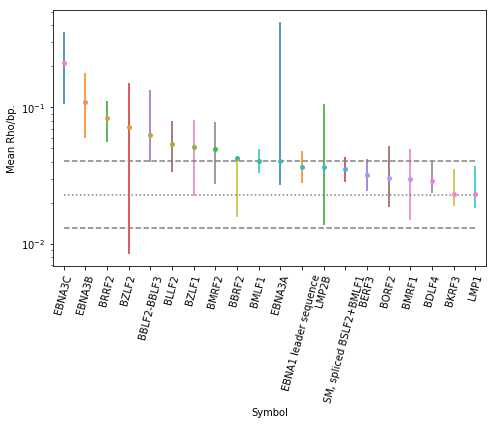

In [19]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

%pylab inline
pylab.rcParams['figure.figsize'] = (7, 6)

plt.figure()
ax = plt.subplot(111)

#aux = res2[res2.Symbol.isin(gsymbols)]
df =res2.head(20)
sns.stripplot(x="Symbol", y="Mean Rho/bp.", data=df,ax = ax);


for x,xlabel in zip(ax.get_xticks(), ax.get_xticklabels()):
    f = df['Symbol'] == xlabel.get_text() 
    y_low = df['Mean Rho/bp.'][f].values - df['-95% CI'][f].values
    y_up = df['+95% CI'][f].values - df['Mean Rho/bp.'][f].values
    ax.errorbar(np.ones_like(df['Mean Rho/bp.'][f].values)*x,df['Mean Rho/bp.'][f].values, yerr=[y_low,y_up], ls='none')
ax.set_yscale('log')

x =ax.get_xticks() 
y,y_low,y_up = rrate.apply(mean_value_by_integration)
ax.plot(x, [y]*len(x), ':',color = 'gray')
ax.plot(x, [y_low]*len(x), '--',color = 'gray')
ax.plot(x, [y_up]*len(x), '--',color = 'gray')

for item in ax.get_xticklabels():
    item.set_rotation(75)
plt.tight_layout()    
#t.savefig('/home/ariel/Projects/Gutierrez/EBV-recomb/recomb/rdp4_results/ids_171_ebv/10Miter/results/rho_by_gene.png',dpi=500)

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['f', 'xlabel']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


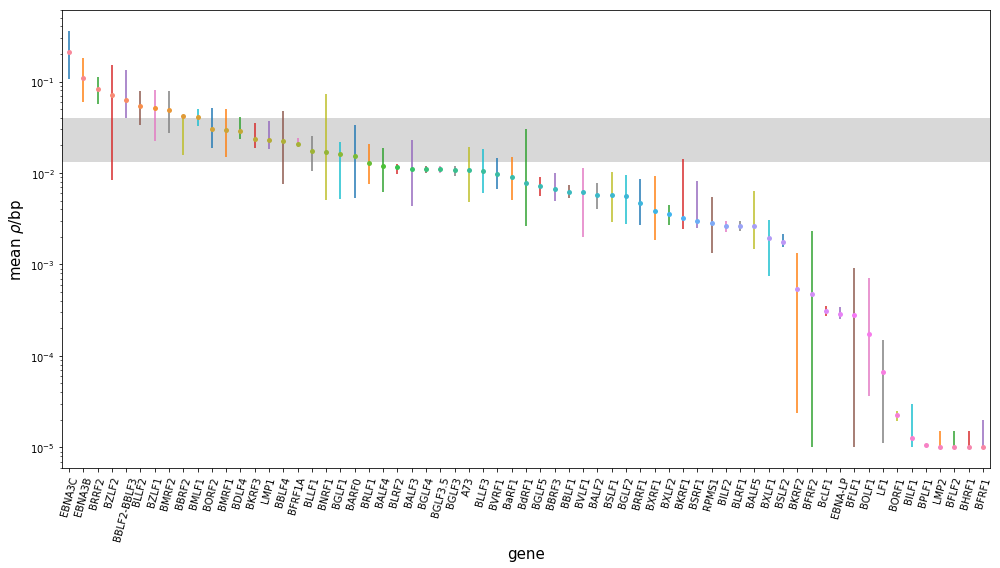

In [20]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

%pylab inline
pylab.rcParams['figure.figsize'] = (14, 8)

plt.figure()
ax = plt.subplot(111)

gsymbols = merged.Symbol.unique()
aux = res2[(res2.Symbol.isin(gsymbols))&(~res2['Mean Rho/bp.'].isnull())]

df =aux.drop_duplicates(subset=['Symbol'])
sns.stripplot(x="Symbol", y="Mean Rho/bp.", data=df,ax = ax);


for x,xlabel in zip(ax.get_xticks(), ax.get_xticklabels()):
    f = df['Symbol'] == xlabel.get_text() 
    y_low = df['Mean Rho/bp.'][f].values - df['-95% CI'][f].values
    y_up = df['+95% CI'][f].values - df['Mean Rho/bp.'][f].values
    ax.errorbar(np.ones_like(df['Mean Rho/bp.'][f].values)*x,df['Mean Rho/bp.'][f].values, yerr=[y_low,y_up], ls='none')
ax.set_yscale('log')

x =ax.get_xticks() 
y,y_low,y_up = rrate.apply(mean_value_by_integration)
#ax.plot(x, [y]*len(x), ':',color = 'gray')
#ax.plot(x, [y_low]*len(x), '--',color = 'gray')
#ax.plot(x, [y_up]*len(x), '--',color = 'gray')
ax.set_ylabel("mean %s/bp"%r'$\rho$',fontsize=15)
ax.set_xlabel("gene",fontsize=15)

currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((np.min(x)-1,y_low), np.max(x)-np.min(x)+2,y_up-y_low, facecolor="grey",alpha = 0.3) )   
              
#rotate xticks               
for item in ax.get_xticklabels():
    item.set_rotation(75)
plt.tight_layout() 


#plt.savefig('/home/ariel/Projects/Gutierrez/EBV-recomb/recomb/rdp4_results/ids_171_ebv/10Miter/results/rho_by_gene_ALLGENES.jpg',dpi=300)
#plt.close()

In [21]:
aux.Symbol.nunique()

65

In [22]:
rrates_reference = pd.merge(mapp[['refCoord','trimmedCoord']],rrate.reset_index(),how='inner',left_on='trimmedCoord',right_on='trimmed_position')
rrates_reference.head()
rrates_reference.set_index(['refCoord'],inplace = True)
rrates_reference.drop(['trimmedCoord','trimmed_position'],1,inplace = True)
#rrates_reference['Mean Rho/bp.'].plot()

In [23]:
%pylab inline

from Bio import AlignIO 
from Bio import SeqIO
seq_record = SeqIO.read(genbank_ref_file,'genbank')

def plot_init(start, end):
    a = start
    b = end
    aux = rrates_reference.loc[a-10:b+10,:]['Mean Rho/bp.'].copy()
    print(aux)
    for x in [a-10,min(aux.index)-2,max(aux.index)+2]:
        if x not in aux.index:
            aux[x] = 0.00001
    aux = aux.to_frame()
    aux.sort_index(inplace = True)
    pylab.rcParams['figure.figsize'] = (10, 6)

    #f, (ax1, ax2) = plt.subplots(1, 1, sharex=True)
    #ax1.hist(rrates_reference.reset_index().ref`Coord,bins = 300)
    #ax1.set_xlim([a-10,b+10])
    #ax1.set_title('segregating sites coverage')
    #ax1.set_ylabel('counts')
    #ax1.grid()

    plt.plot(aux['Mean Rho/bp.'])
    plt.xlabel('genome possition',fontsize = 20)
    plt.xlim([a-10,b+10])
    #plt.title('population rho')
    plt.ylabel( "%s/bp"%r'$\rho$',fontsize = 20)
    rang = range(a-10,b+10)
    ss = []
    for j in rang:
        if (j>=(a-1))&(j<=(b-2)):
            ss.append(seq_record.seq[j])
        else:
            if j%5==0:
                ss.append(j)
            else:
                ss.append('')
                
    plt.xticks(rang,ss,rotation=45,fontsize=15)
    plt.yticks(fontsize=15)
    plt.grid()


Populating the interactive namespace from numpy and matplotlib


refCoord
81254    0.01462
81256    0.01462
81258    0.01462
81260    0.01462
81262    0.01462
Name: Mean Rho/bp., dtype: float64


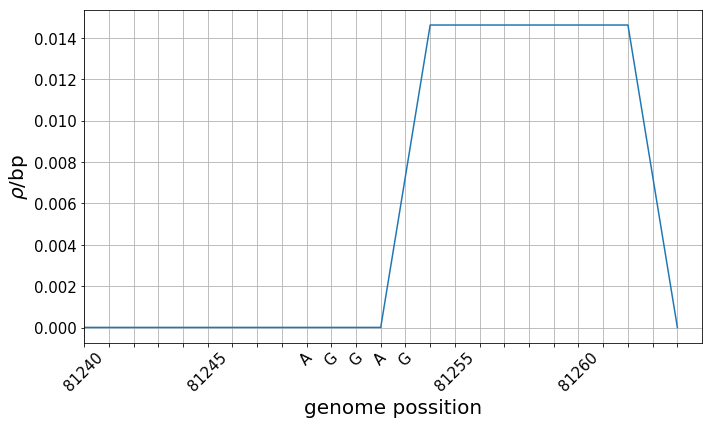

In [24]:
#a,b =133491,133496
a,b = 81250,81255

plot_init(a,b) 
plt.tight_layout()
#plt.savefig(outpath +'recombination_init_example_%s.png'%a,dpi = 500,figsize = (5,5))


In [25]:
## PREPARO FIGURA 1 PANEL C
import seaborn as sns
from Bio import SeqIO
seq_record = SeqIO.read(genbank_ref_file,'genbank')

types = []
cds = []
region =[]
for feature in seq_record.features:
    types.append(feature.type)
    if 'gene' in feature.qualifiers.keys():
        gene = feature.qualifiers['gene']
    else:
        gene = 'None'
    
    partes = []
    for p in feature.location.parts:
        partes.append(pd.Series([p.start.position,p.end.position]))
    positions = pd.concat(partes,1).transpose()    
    positions.columns = ['start','end']
    positions['type'] = feature.type
    positions['gene'] = np.repeat(gene,positions.shape[0])

    
    region.append(positions)
regions = pd.concat(region)

regions = regions[regions.type!='source']

# compute length of each region
regions['length'] = regions.end - regions.start
regions['length'] = pd.to_numeric(regions.length)

regions = regions[regions.length < 40000] # con esto tiramos la anomalia del primer gen. 


regions['rango'] = regions.apply(lambda x: (x.start,x.end),1)
regions.set_index('rango',inplace = True)
regions.head()

# tomo la coordenada de la region o la siguiente (o anterior) para mapearlas al alineamiento
start_prima = [x if x in mapp_dict.keys()  else (x +1 ) for x in regions.start.values]
end_prima = [x if x in mapp_dict.keys()  else (x -1 ) for x in regions.end.values]

# mapp to trimmed alignment
regions['trimmed_st'] = get_items(mapp_dict,start_prima)
regions['trimmed_end'] = get_items(mapp_dict,end_prima)
regions['length_aln'] = regions['trimmed_end'] - regions['trimmed_st']


res3 = regions.apply(lambda x: pd.concat([x[2:4],rrate[x.trimmed_st:x.trimmed_end].apply(mean_value_by_integration),x[0:2],x[-4::]]),axis =1)
res3.sort_values(by=['Mean Rho/bp.'],inplace=True,ascending = False)



/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.


In [26]:
def mapp_and_compute_rho(df,start_col = 'st',end_col = 'end'):
    df = df.dropna(subset=[start_col,end_col])
    start_aux = [x if x in mapp_dict.keys() else (x +1 ) for x in df[start_col].values]
    end_aux = [x if x in mapp_dict.keys() else (x -1 ) for x in df[end_col].values]


    df['trimmed_st'] = get_items(mapp_dict,start_aux)
    df['trimmed_end'] = get_items(mapp_dict,end_aux)

    computed_rates = df.apply(lambda x: pd.concat([x,compute_local_obs(rrate,r1 = x.trimmed_st,r2 = x.trimmed_end)]),axis =1)
    return df,computed_rates

In [27]:
### Spike detection for gene name ploting

spikes = mapp[mapp.trimmedCoord.isin(rrate[rrate['Mean Rho/bp.']>0.03].index)].refCoord
gene_coords_file = '/data/EBV/by_gene/gene_result_lmp2.csv'
gene_coords = pd.read_csv(gene_coords_file,sep = '\t')

Gst = gene_coords.start_position_on_the_genomic_accession
Gend= gene_coords.end_position_on_the_genomic_accession

spikerGenes = []
for sp in spikes.values:
    symb = gene_coords[(Gst<sp)&(Gend>sp)].Symbol
    
    if (type(symb) == pd.core.series.Series):
        if(len(symb.values))>0:
            for v in symb.values:
                spikerGenes.append(pd.Series({v:sp}))
    else:
        spikerGenes.append(pd.Series({symb[0]:sp}))

spikerGenes = pd.concat(spikerGenes).to_frame().reset_index()
spikerGenes.columns = ['gen','pos']

gsymbols = merged.Symbol.unique()  # esta linea viene de arriba, del plot x gen (que codififca)
spikerGenes['dif'] = [1001]+ list(spikerGenes.pos[1:].values - spikerGenes.pos[:-1].values)
spikerGenes = spikerGenes[spikerGenes.dif>1000]
spikerGenes = spikerGenes[spikerGenes.gen.isin(gsymbols)]
spikerGenes.reset_index(inplace=True)
spikerGenes.drop('index',axis=1,inplace=True)
spikerGenes.gen.replace({'EBNA3B':'EBNA3'},inplace=True)

In [28]:
spikerGenes2 = []
for sp in spikes.values:
    symb = gene_coords[(Gst<sp)&(Gend>sp)].Symbol
    
    if (type(symb) == pd.core.series.Series):
        if(len(symb.values))>0:
            for v in symb.values:
                spikerGenes2.append(pd.Series({v:sp}))
    else:
        spikerGenes2.append(pd.Series({symb[0]:sp}))

spikerGenes2 = pd.concat(spikerGenes2).to_frame().reset_index()
spikerGenes2.columns = ['gen','pos']

gsymbols = merged.Symbol.unique()  # esta linea viene de arriba, del plot x gen (que codififca)
spikerGenes2['dif'] = [1001]+ list(spikerGenes2.pos[1:].values - spikerGenes2.pos[:-1].values)

unique(spikerGenes2.gen.values)

array(['A73', 'BALF3', 'BALF4', 'BALF5', 'BARF0', 'BBLF2-BBLF3', 'BBLF4',
       'BBRF2', 'BDLF4', 'BERF3', 'BFLF1', 'BFRF1A', 'BFRF2', 'BGLF1',
       'BGLF5', 'BKRF3', 'BLLF1', 'BLLF2', 'BLLF3', 'BMLF1', 'BMRF1',
       'BMRF2', 'BNRF1', 'BORF2', 'BRLF1', 'BRRF1', 'BRRF2', 'BSLF1',
       'BVLF1', 'BVRF1', 'BVRF2', 'BXLF1', 'BXRF1', 'BZLF1', 'BZLF2',
       'BaRF1', 'BdRF1', 'EBNA1 leader sequence', 'EBNA3A', 'EBNA3B',
       'EBNA3C', 'LMP1', 'LMP2B', 'RPMS1', 'RZ fusion',
       'SM, spliced BSLF2+BMLF1'], dtype=object)

Populating the interactive namespace from numpy and matplotlib


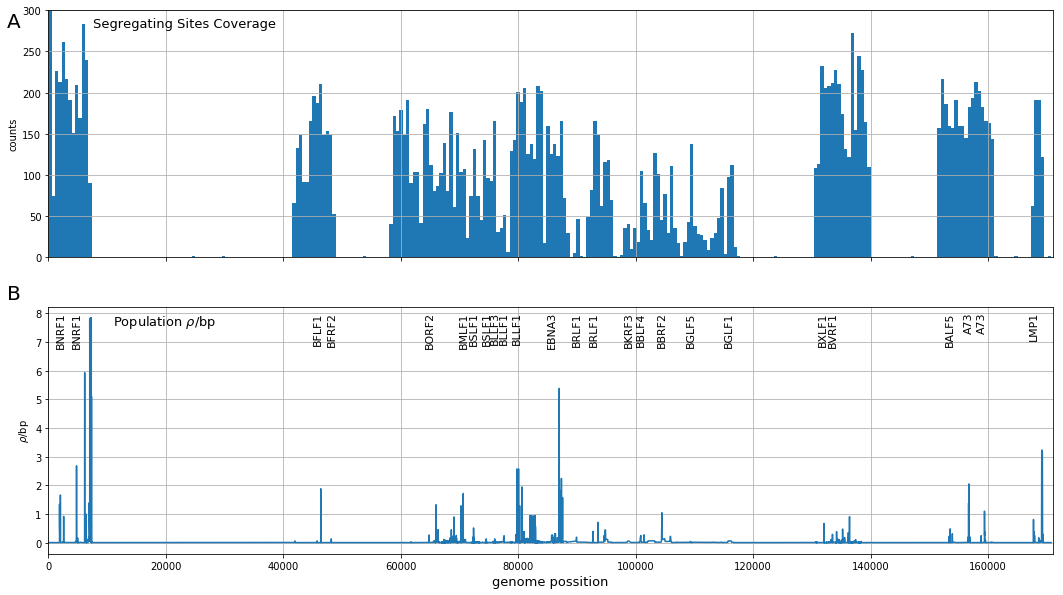

In [450]:
rrates_reference = pd.merge(mapp[['refCoord','trimmedCoord']],rrate.reset_index(),how='inner',left_on='trimmedCoord',right_on='trimmed_position')
rrates_reference.head()
rrates_reference.set_index(['refCoord'],inplace = True)
rrates_reference.drop(['trimmedCoord','trimmed_position'],1,inplace = True)
rrates_reference['Mean Rho/bp.'].plot()

%pylab inline
pylab.rcParams['figure.figsize'] = (18, 10)

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.hist(rrates_reference.reset_index().refCoord,bins = 300)
ax1.set_xlim([0,171000])
ax1.text(x=7600,y=280,s='Segregating Sites Coverage',fontsize = 13)
ax1.text(x=-7000,y=280,s='A',fontsize = 20)

ax1.set_ylabel('counts')
ax1.set_ylim((0,300))
ax1.grid()

ax2.plot(rrates_reference['Mean Rho/bp.'])
#ax2.set_yscale('log')

ax2.set_xlabel('genome possition',fontsize=13)
ax2.text(x=-7000,y=8.5,s='B',fontsize = 20)
ax2.text(x=11000,y=7.6,s='Population %s/bp'%r'$\rho$',fontsize = 13)
ax2.set_ylabel('%s/bp'%r'$\rho$')
#ax2.set_ylim([0,9.5])
ax2.grid()

for ii in range(spikerGenes.shape[0]):
    g = spikerGenes.loc[ii,'gen']
    if g not in ['BXLF1','BVRF1']:
        ax2.text(x=spikerGenes.loc[ii,'pos']-700,y=7.8,s=g,fontsize = 11,rotation =90)
    else:
        if g not in 'BVRF1':
            ax2.text(x=spikerGenes.loc[ii,'pos']-1000,y=7.8,s=g,fontsize = 11,rotation =90)
        else:
            ax2.text(x=spikerGenes.loc[ii,'pos']-500,y=7.8,s=g,fontsize = 11,rotation =90)
        

result_by_region = res3.copy()
chauguion = {'repeat_region':'repeat region','misc_feature':"misc. feature"}
result_by_region.type.replace(chauguion,inplace = True)

size_thr = 10
ok = result_by_region.type[~result_by_region['Mean Rho/bp.'].isnull()].value_counts()
ok = ok[ok>=size_thr].index
filter_data = result_by_region[result_by_region.type.isin(ok)]
mm = filter_data.groupby(['type'])['Mean Rho/bp.'].median()
order =  mm.sort_values(ascending=False).index
#plt.savefig(outpath+'Fig1_ab.png',dpi=500)


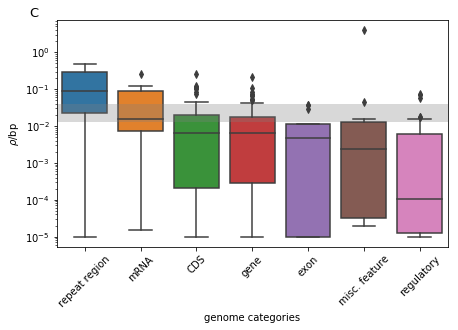

In [130]:
pylab.rcParams['figure.figsize'] = (12, 5)

ax3 = sns.boxplot(x ='type',y = 'Mean Rho/bp.', data = filter_data,order = order)
ax3.set_yscale('log')
ax3.set_ylabel('%s/bp'%r'$\rho$')
ax3.set_xlabel('genome categories')
ax3.text(x=-1,y=9,s='C',fontsize = 13)
### add mean range of whole genome ##

x =ax3.get_xticks() 
y,y_low,y_up = rrate.apply(mean_value_by_integration)
currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((np.min(x)-1,y_low), np.max(x)-np.min(x)+2,y_up-y_low, facecolor="grey",alpha = 0.3) )   


for item in ax3.get_xticklabels():
    item.set_rotation(45)
plt.gcf().subplots_adjust(bottom=0.25)
plt.savefig(outpath+'Fig1_c.png',dpi=500)

In [224]:
stats = {}
sup_table1 = []
for idds in ids.acc:
    idd = idds.split('.')[0]
    s = SeqIO.read('/home/ariel/data/EBV/byACCIDs/genBankRecord_%s.gb'%idd,"genbank")
    stats.update({idd:len(s.annotations['references'])})

    f = s.annotations['references'][0]
    if f.journal =='Unpublished':
        f =  s.annotations['references'][1]

#    sup_table1.append(pd.Series({'accession':idd,'authors':f.authors,'journal':f.journal,'pubmed_id':f.pubmed_id,'title':f.title}))
    sup_table1.append(pd.Series({'accession':idd,'authors':f.authors,'journal':f.journal}))

sup_table = pd.concat(sup_table1,axis = 1).transpose()
sup_table.set_index('accession',inplace = True)    

sup_table.to_csv('/home/ariel/Projects/Gutierrez/EBV-recomb/recomb/rdp4_results/ids_171_ebv/10Miter/results/ST1.csv')
#pd.Series(stats).value_counts()

In [216]:
counts = pd.Series(stats)
counts[counts>2]

AJ507799     21
AY961628      5
DQ279927      4
JQ009376      3
KF373730      3
M80517        4
NC_007605    22
NC_009334     5
V01555       19
dtype: int64

## GC content

In [29]:
#result_by_region['gc'] 
def gc_content(seq):
    gs = seq.count('G')
    cs = seq.count('C')
    return (gs+cs)/float(len(seq))
#a= result_by_region.apply(lambda x : gc_content(seq_record.seq[x.loc['st']: x.loc['end']]),1)
#a

In [33]:
from Bio import SeqIO
genbank_ref_file = '/data/EBV/byACCIDs/genBankRecord_NC_007605.gb'
seq_record = SeqIO.read(genbank_ref_file,'genbank')

types = []
cds = []
region =[]
for feature in seq_record.features:
    types.append(feature.type)
    if 'gene' in feature.qualifiers.keys():
        gene = feature.qualifiers['gene']
    else:
        gene = 'None'
    
    partes = []
    for p in feature.location.parts:
        partes.append(pd.Series([p.start.position,p.end.position]))
    positions = pd.concat(partes,1).transpose()    
    positions.columns = ['start','end']
    positions['type'] = feature.type
    positions['gene'] = np.repeat(gene,positions.shape[0])

    
    region.append(positions)
regions = pd.concat(region)

regions = regions[regions.type!='source']

# compute length of each region
regions['length'] = regions.end - regions.start
regions['length'] = pd.to_numeric(regions.length)

regions = regions[regions.length < 40000] # con esto tiramos la anomalia del primer gen. 
regions.rename(columns={'gene':'GENE','type':'call','start':'st'},inplace = True)
_, regions_rho = mapp_and_compute_rho(regions)
reg_rho = regions_rho[['call','GENE','Mean Rho/bp.','-95% CI','+95% CI']]

In [36]:
def gc_content(seq):
    gs = seq.count('G')
    cs = seq.count('C')
    return (gs+cs)/float(len(seq))

reg_rho_gc = regions_rho.copy()#[['call','GENE','Mean Rho/bp.','-95% CI','+95% CI']]
reg_rho_gc['gc'] = regions.apply(lambda x : gc_content(seq_record.seq[x.loc['st']: x.loc['end']]),1)


array(['EBNA-LP', 'LMP2', 'LMP1', 'BLLF1', 'BMRF1', 'BZLF2', 'BALF4',
       'BKRF1', 'BdRF1', 'BGLF4', 'BPLF1', 'BZLF1', 'BMLF1', 'BHRF1',
       'EBNA3C', 'BALF5', 'BLLF3', 'BMRF2', 'BGLF5', 'BXLF2', 'BBRF3',
       'BLRF1', 'BALF1', 'BFRF2', 'BILF1', 'BKRF4', 'BRRF1', 'BRRF2',
       'BLLF2', 'BLRF2', 'BILF2', 'BGLF2', 'BBLF1', 'BBRF2', 'BGLF1',
       'BVRF1', 'BALF2', 'EBNA3B', 'BKRF2', 'BOLF1', 'BXLF1', 'LF1',
       'BcLF1', 'BNRF1', 'BFLF2', 'BFRF1', 'BSLF1', 'BaRF1', 'BORF2',
       'RPMS1', 'BRLF1', 'BSRF1', 'BALF3', 'BORF1', 'BDLF4', 'BXRF1',
       'BKRF3', 'BFLF1', 'BGLF3', 'BSLF2', 'BARF0', 'BVLF1', 'A73',
       'BGLF3.5', 'BBLF2-BBLF3', 'BFRF1A', 'BBLF4'], dtype=object)

In [87]:
#aux = reg_rho_gc.copy()
gprots = merged.Symbol.unique()
aux = reg_rho_gc.dropna(subset=['Mean Rho/bp.'])
aaux = aux.groupby(['GENE'])[['Mean Rho/bp.','gc']].mean()

ii = gprots[pd.Series(gprots).isin(aaux.index)]
aaux = aaux.loc[ii,:]

In [ ]:
out

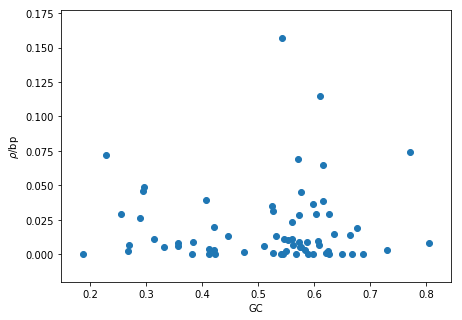

In [100]:
#aux = reg
pylab.rcParams['figure.figsize'] = (7,5)

plt.scatter(aaux.gc,aaux['Mean Rho/bp.'])
plt.xlabel('GC')
plt.ylabel('%s/bp'%r'$\rho$')
plt.savefig(outpath+'GCcontent_vs_rho.png',res=500)

In [92]:
from scipy.stats import spearmanr
spearmanr(aaux.gc,aaux['Mean Rho/bp.'])
#stat(aaux.gc,aaux['Mean Rho/bp.'])

SpearmanrResult(correlation=-0.022069240750677163, pvalue=0.8592990429054963)

In [ ]:
start_prima = [x if x in mapp_dict.keys()  else (x +1 ) for x in regions.start.values]
end_prima = [x if x in mapp_dict.keys()  else (x -1 ) for x in regions.end.values]

# mapp to trimmed alignment
regions['trimmed_st'] = get_items(mapp_dict,start_prima)
regions['trimmed_end'] = get_items(mapp_dict,end_prima)
regions['length_aln'] = regions['trimmed_end'] - regions['trimmed_st']


result_by_region = regions.apply(lambda x: pd.concat([x[2:4],rrate[x.trimmed_st:x.trimmed_end].apply(mean_value_by_integration),x[0:2],x[-4::]]),axis =1)
result_by_region.sort_values(by=['Mean Rho/bp.'],inplace=True,ascending = False)


out2 = outpath+'result_by_region'+suffix +'.csv'


In [ ]:
from Bio import SeqIO
seq_record = SeqIO.read(genbank_ref_file,'genbank')

types = []
cds = []
region =[]
for feature in seq_record.features:
    types.append(feature.type)
    if 'gene' in feature.qualifiers.keys():
        gene = feature.qualifiers['gene']
    else:
        gene = 'None'
    
    partes = []
    for p in feature.location.parts:
        partes.append(pd.Series([p.start.position,p.end.position]))
    positions = pd.concat(partes,1).transpose()    
    positions.columns = ['start','end']
    positions['type'] = feature.type
    positions['gene'] = np.repeat(gene,positions.shape[0])

    
    region.append(positions)
regions = pd.concat(region)

regions = regions[regions.type!='source']


In [91]:
size_thr = 10


from Bio import SeqIO
seq_record = SeqIO.read(genbank_ref_file,'genbank')

types = []
cds = []
region =[]
for feature in seq_record.features:
    types.append(feature.type)
    if 'gene' in feature.qualifiers.keys():
        gene = feature.qualifiers['gene']
    else:
        gene = 'None'
    
    partes = []
    for p in feature.location.parts:
        partes.append(pd.Series([p.start.position,p.end.position]))
    positions = pd.concat(partes,1).transpose()    
    positions.columns = ['start','end']
    positions['type'] = feature.type
    positions['gene'] = np.repeat(gene,positions.shape[0])

    
    region.append(positions)
regions = pd.concat(region)

regions = regions[regions.type!='source']

# compute length of each region
regions['length'] = regions.end - regions.start
regions['length'] = pd.to_numeric(regions.length)

regions = regions[regions.length < 40000] # con esto tiramos la anomalia del primer gen. 
res3 = regions.apply(lambda x: pd.concat([x[2:4],rrate[x.trimmed_st:x.trimmed_end].apply(mean_value_by_integration),x[0:2],x[-4::]]),axis =1)
res3.sort_values(by=['Mean Rho/bp.'],inplace=True,ascending = False)

result_by_region = res3.copy()


ok = result_by_region.type[~result_by_region['Mean Rho/bp.'].isnull()].value_counts()
ok = ok[ok>=size_thr].index
filter_data = result_by_region[result_by_region.type.isin(ok)]
mm = filter_data.groupby(['type'])['Mean Rho/bp.'].median()
order =  mm.sort_values(ascending=False).index

ax = sns.boxplot(x ='type',y = 'Mean Rho/bp.', data = filter_data,order = order)
ax.set_yscale('log')
ax.set_ylabel('4Ne.r/bp')
ax.set_xlabel('genome region')

### add mean range of whole genome ##

x =ax.get_xticks() 
y,y_low,y_up = rrate.apply(mean_value_by_integration)
currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((np.min(x)-1,y_low), np.max(x)-np.min(x)+2,y_up-y_low, facecolor="grey",alpha = 0.3) )   



for item in ax.get_xticklabels():
    item.set_rotation(45)
plt.gcf().subplots_adjust(bottom=0.25)
#plt.savefig(outpath+'boxplot_by_region'+suffix+'.png',dpi = 500)




NameError: name 'res3' is not defined

/usr/local/lib/python2.7/dist-packages/Bio/Seq.py:349: BiopythonDeprecationWarning: This method is obsolete; please use str(my_seq) instead of my_seq.tostring().
  BiopythonDeprecationWarning)


'AGGAG'

81249
81250
81251
81252
81253
81254


In [174]:
ss

['A',
 'A',
 'C',
 'A',
 'G',
 'G',
 'G',
 'C',
 'A',
 'A',
 'G',
 'G',
 'A',
 'G',
 'G',
 'T',
 'A',
 'C',
 'T',
 'G',
 'G',
 'A',
 'A',
 'A',
 'A']

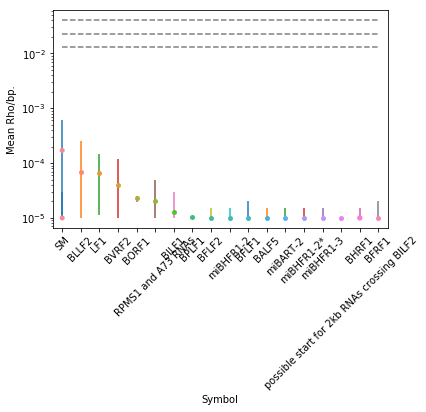

In [18]:
plt.figure()
ax = plt.subplot(111)

df =res2[~res2['Mean Rho/bp.'].isnull()].tail(20)
sns.stripplot(x="Symbol", y="Mean Rho/bp.", data=df,ax = ax);


for x,xlabel in zip(ax.get_xticks(), ax.get_xticklabels()):
    f = df['Symbol'] == xlabel.get_text() 
    y_low = df['Mean Rho/bp.'][f].values - df['-95% CI'][f].values
    y_up = df['+95% CI'][f].values - df['Mean Rho/bp.'][f].values
    ax.errorbar(np.ones_like(df['Mean Rho/bp.'][f].values)*x,df['Mean Rho/bp.'][f].values, yerr=[y_low,y_up], ls='none')
ax.set_yscale('log')

x =ax.get_xticks() 
y,y_low,y_up = rrate.apply(mean_value_by_integration)
ax.plot(x, [y]*len(x), '--',color = 'gray')
ax.plot(x, [y_low]*len(x), '--',color = 'gray')
ax.plot(x, [y_up]*len(x), '--',color = 'gray')

for item in ax.get_xticklabels():
    item.set_rotation(45)


In [19]:
print 'sin señal %s genes'%res2['Mean Rho/bp.'].isnull().sum()
print 'CON señal %s genes'% (~res2['Mean Rho/bp.'].isnull()).sum()

sin señal 62 genes
CON señal 90 genes


In [45]:
(~res2.GeneID.apply(lambda x: int(str(x)[0:2])==17)).sum()


84

In [61]:
gobackground = pd.read_table('/home/ariel/Projects/Gutierrez/EBV-recomb/recomb/GOanalysis/GO-EBV-Uniprot.tab')
gids = gobackground['Cross-reference (GeneID)'].str.split(';',expand=False).apply(lambda x: [a  for a in x if a not in ''])
gidslist = pd.to_numeric(pd.concat([pd.Series(x) for x in gids.values]))
gidframe = gidslist.reset_index().drop(['index'],axis=1)
gobackground.Entry.nunique()

92

In [72]:
protein_coding_genes = gidframe[0]
#protein_coding_genes

In [79]:
res2.columns

Index([u'GeneID', u'Symbol', u'Aliases', u'Mean Rho/bp.', u'-95% CI',
       u'+95% CI', u'start_position_on_the_genomic_accession',
       u'end_position_on_the_genomic_accession', u'trimmed_st', u'trimmed_end',
       u'length_aln', u'length'],
      dtype='object')

In [85]:
protein_coding_genes.nunique()

91

In [92]:
N_protein_coding_genes = float(protein_coding_genes.nunique())
with_signal = res2[((res2.GeneID.isin(protein_coding_genes))&(~res2['Mean Rho/bp.'].isnull()))]

without_signal = res2[((res2.GeneID.isin(protein_coding_genes))&(res2['Mean Rho/bp.'].isnull()))]

with_signal.shape[0]/N_protein_coding_genes

0.7362637362637363

In [98]:
with_signal.shape[0] + without_signal.shape[0]

91

In [96]:
without_signal.head()

,GeneID,Symbol,Aliases,Mean Rho/bp.,-95% CI,+95% CI,start_position_on_the_genomic_accession,end_position_on_the_genomic_accession,trimmed_st,trimmed_end,length_aln,length
1,3783677,BALF1,NaN,NaN,NaN,NaN,164388.0,165255.0,167736,168611,875,867.0
9,3783772,BARF1,HHV4_BARF1.2,NaN,NaN,NaN,165008.0,165712.0,168364,169071,707,704.0
25,3783689,BCRF1,HHV4_BCRF1.1,NaN,NaN,NaN,9631.0,10262.0,9832,10464,632,631.0
26,3783690,BcRF1,NaN,NaN,NaN,NaN,125177.0,127429.0,127740,130041,2301,2252.0
28,3783691,BCRF2,HHV4_BWRF1.1,NaN,NaN,NaN,12541.0,13692.0,12758,13909,1151,1151.0


In [15]:
#res2.to_csv(outfile,sep ='|',index = False)

In [18]:
from Bio import AlignIO 
from Bio import SeqIO
seq_record = SeqIO.read(genbank_ref_file,'genbank')

In [22]:
from Bio import SeqIO
seq_record = SeqIO.read(genbank_ref_file,'genbank')

types = []
cds = []
region =[]
for feature in seq_record.features:
    types.append(feature.type)
    if 'gene' in feature.qualifiers.keys():
        gene = feature.qualifiers['gene']
    else:
        gene = 'None'
    
    partes = []
    for p in feature.location.parts:
        partes.append(pd.Series([p.start.position,p.end.position]))
    positions = pd.concat(partes,1).transpose()    
    positions.columns = ['start','end']
    positions['type'] = feature.type
    positions['gene'] = np.repeat(gene,positions.shape[0])

    
    region.append(positions)
regions = pd.concat(region)

regions = regions[regions.type!='source']

# compute length of each region
regions['length'] = regions.end - regions.start
regions['length'] = pd.to_numeric(regions.length)

regions = regions[regions.length < 40000] # con esto tiramos la anomalia del primer gen. 

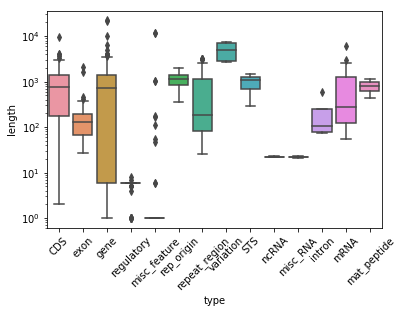

In [103]:
ax = sns.boxplot(x ='type',y = 'length', data = regions)
ax.set_yscale('log')

for item in ax.get_xticklabels():
    item.set_rotation(45)

In [24]:
regions['rango'] = regions.apply(lambda x: (x.start,x.end),1)
regions.set_index('rango',inplace = True)
regions.head()

,start,end,type,gene,length
rango,,,,,
"(166102, 166458)",166102,166458,CDS,LMP2,356
"(57, 272)",57,272,CDS,LMP2,215
"(359, 458)",359,458,CDS,LMP2,99
"(539, 788)",539,788,CDS,LMP2,249
"(870, 951)",870,951,CDS,LMP2,81


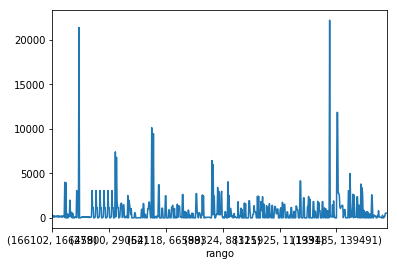

In [25]:
regions.length.plot()

In [33]:
pd.Series(mapp_dict).tail()

171819    177032
171820    177033
171821    177034
171822    177035
171823    177036
dtype: int64

In [55]:
# tomo la coordenada de la region o la siguiente (o anterior) para mapearlas al alineamiento
start_prima = [x if x in mapp_dict.keys()  else (x +1 ) for x in regions.start.values]
end_prima = [x if x in mapp_dict.keys()  else (x -1 ) for x in regions.end.values]

# mapp to trimmed alignment
regions['trimmed_st'] = get_items(mapp_dict,start_prima)
regions['trimmed_end'] = get_items(mapp_dict,end_prima)
regions['length_aln'] = regions['trimmed_end'] - regions['trimmed_st']

In [58]:
regions.head()

,start,end,type,gene,length,trimmed_st,trimmed_end,length_aln
rango,,,,,,,,
"(166102, 166458)",166102,166458,CDS,LMP2,356,169465,169829,364
"(57, 272)",57,272,CDS,LMP2,215,57,272,215
"(359, 458)",359,458,CDS,LMP2,99,360,458,98
"(539, 788)",539,788,CDS,LMP2,249,539,788,249
"(870, 951)",870,951,CDS,LMP2,81,871,951,80


In [66]:
from Bio import SeqIO
seq_record = SeqIO.read(genbank_ref_file,'genbank')

types = []
cds = []
region =[]
for feature in seq_record.features:
    types.append(feature.type)
    if 'gene' in feature.qualifiers.keys():
        gene = feature.qualifiers['gene']
    else:
        gene = 'None'
    
    partes = []
    for p in feature.location.parts:
        partes.append(pd.Series([p.start.position,p.end.position]))
    positions = pd.concat(partes,1).transpose()    
    positions.columns = ['start','end']
    positions['type'] = feature.type
    positions['gene'] = np.repeat(gene,positions.shape[0])

    
    region.append(positions)
regions = pd.concat(region)

regions = regions[regions.type!='source']

# compute length of each region
regions['length'] = regions.end - regions.start
regions['length'] = pd.to_numeric(regions.length)

regions = regions[regions.length < 40000] # con esto tiramos la anomalia del primer gen. 


regions['rango'] = regions.apply(lambda x: (x.start,x.end),1)
regions.set_index('rango',inplace = True)
regions.head()

# tomo la coordenada de la region o la siguiente (o anterior) para mapearlas al alineamiento
start_prima = [x if x in mapp_dict.keys()  else (x +1 ) for x in regions.start.values]
end_prima = [x if x in mapp_dict.keys()  else (x -1 ) for x in regions.end.values]

# mapp to trimmed alignment
regions['trimmed_st'] = get_items(mapp_dict,start_prima)
regions['trimmed_end'] = get_items(mapp_dict,end_prima)
regions['length_aln'] = regions['trimmed_end'] - regions['trimmed_st']


res3 = regions.apply(lambda x: pd.concat([x[2:4],rrate[x.trimmed_st:x.trimmed_end].apply(mean_value_by_integration),x[0:2],x[-4::]]),axis =1)
res3.sort_values(by=['Mean Rho/bp.'],inplace=True,ascending = False)

res3.head()

mm = res3.groupby(['type'])['Mean Rho/bp.'].median()
order =  mm.sort_values(ascending=False).index

ax = sns.boxplot(x ='type',y = 'Mean Rho/bp.', data = res3,order = order)
ax.set_yscale('log')

for item in ax.get_xticklabels():
    item.set_rotation(45)
    
    

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.


,type,gene,Mean Rho/bp.,-95% CI,+95% CI,start,end,length,trimmed_st,trimmed_end,length_aln
rango,,,,,,,,,,,
"(6955, 7128)",misc_feature,LMP2,3.567325,0.263320,3.526180,6955,7128,173,7064,7237,173
"(82607, 82694)",repeat_region,LMP2,0.463480,0.224340,0.634265,82607,82694,87,84102,84189,87
"(82097, 82123)",repeat_region,LMP2,0.457779,0.255647,1.730553,82097,82123,26,83568,83594,26
"(82123, 82201)",repeat_region,LMP2,0.355370,0.172202,0.716514,82123,82201,78,83594,83693,99
"(82282, 82360)",repeat_region,LMP2,0.313305,0.150702,0.428909,82282,82360,78,83775,83853,78


In [61]:
res3.columns

Index([u'type', u'gene', u'Mean Rho/bp.', u'-95% CI', u'+95% CI', u'start',
       u'end', u'length', u'trimmed_st', u'trimmed_end', u'length_aln'],
      dtype='object')

In [100]:
GEN =  'EBNA3C'

In [101]:
res2[res2.Symbol ==GEN]

,GeneID,Symbol,Aliases,Mean Rho/bp.,-95% CI,+95% CI,start_position_on_the_genomic_accession,end_position_on_the_genomic_accession,trimmed_st,trimmed_end,length_aln,length
129,17494242,EBNA3C,NaN,0.117717,0.001404,0.3639,86076.0,89502.0,87638,91451,3813,3426.0


In [102]:
res3[res3.gene == GEN]

,type,gene,Mean Rho/bp.,-95% CI,+95% CI,start,end,length,trimmed_st,trimmed_end,length_aln
rango,,,,,,,,,,,
"(86516, 89502)",mRNA,EBNA3C,0.136553,0.001476,0.428858,86516,89502,2986,88078,91451,3373
"(86516, 89135)",CDS,EBNA3C,0.136553,0.001476,0.428858,86516,89135,2619,88078,91084,3006
"(86075, 89502)",gene,EBNA3C,0.117717,0.001404,0.363900,86075,89502,3427,87637,91451,3814
"(86082, 86442)",CDS,EBNA3C,0.035873,0.001168,0.067680,86082,86442,360,87644,88004,360
"(86075, 86442)",mRNA,EBNA3C,0.035326,0.001164,0.066643,86075,86442,367,87637,88004,367
"(87833, 88016)",repeat_region,EBNA3C,NaN,NaN,NaN,87833,88016,183,89561,89747,186
"(88324, 88325)",misc_feature,EBNA3C,NaN,NaN,NaN,88324,88325,1,90056,90056,0
"(88376, 88493)",repeat_region,EBNA3C,NaN,NaN,NaN,88376,88493,117,90107,90419,312
"(88630, 88631)",misc_feature,EBNA3C,NaN,NaN,NaN,88630,88631,1,90558,90559,1


In [69]:
#res3.sort_values(by=['Mean Rho/bp.'],ascending=False)

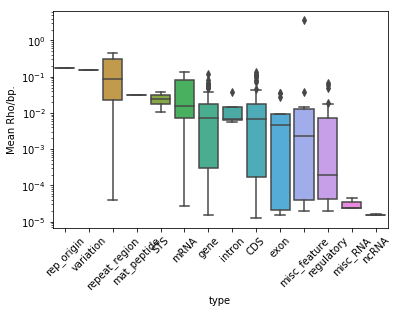

In [70]:
mm = res3.groupby(['type'])['Mean Rho/bp.'].median()
order =  mm.sort_values(ascending=False).index

ax = sns.boxplot(x ='type',y = 'Mean Rho/bp.', data = res3,order = order)
ax.set_yscale('log')

for item in ax.get_xticklabels():
    item.set_rotation(45)

## Analyze RHO vs length

(39, 11)

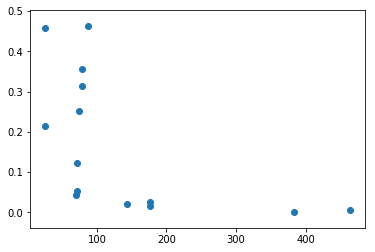

In [132]:
l_rep = res3[res3.type=='repeat_region'].copy()
plt.scatter(l_rep.length,l_rep['Mean Rho/bp.'])
l_rep.shape

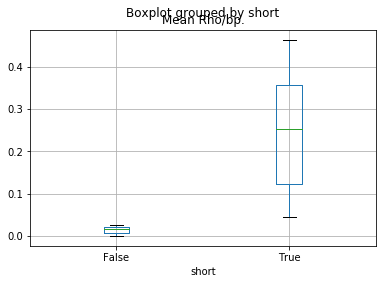

In [138]:
l_rep['short'] =pd.to_numeric(l_rep.length<100)
ax = l_rep.boxplot('Mean Rho/bp.','short')

In [148]:
from scipy import stats
ii = ~l_rep['Mean Rho/bp.'].isnull()
Short = l_rep[ii][l_rep.short]['Mean Rho/bp.'].values
Long = l_rep[ii][~l_rep.short]['Mean Rho/bp.'].values

stats.ttest_ind(Short,Long)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


Ttest_indResult(statistic=3.2815436203053179, pvalue=0.0065613279094290794)

In [149]:
Short = l_rep[l_rep.short]['Mean Rho/bp.'].fillna(0).values
Long = l_rep[~l_rep.short]['Mean Rho/bp.'].fillna(0).values

stats.ttest_ind(Short,Long)

Ttest_indResult(statistic=4.993981953622697, pvalue=1.4370820896406838e-05)

# analyze RNA

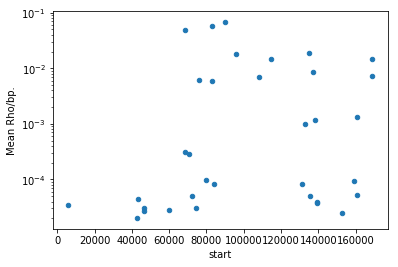

In [199]:
regul = res3[res3.type == 'regulatory']
regul = regul[~regul['Mean Rho/bp.'].isnull()]
regul.plot.scatter(x = 'start' , y = 'Mean Rho/bp.',logy=True)
#s.plot.scatter()
#plt.scatter(regul['length'],regul['Mean Rho/bp.'])

In [243]:
min(x)

-4.6989700043360187

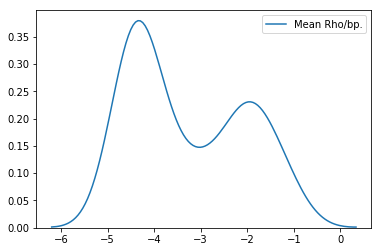

In [248]:
regul = res3[res3.type == 'regulatory']
regul = regul[~regul['Mean Rho/bp.'].isnull()]

x = np.log10(regul['Mean Rho/bp.'])#.plot(kind = 'density')
ax = sns.kdeplot(x,bw = 0.5)
#ax.set_xscale('log')

In [417]:
#regulatorias = regul[regul['Mean Rho/bp.']>0.001][['gene','Mean Rho/bp.','start']]#'+95% CI','start','end']]

## filter only regions with more than 10 annots (with rho signal)

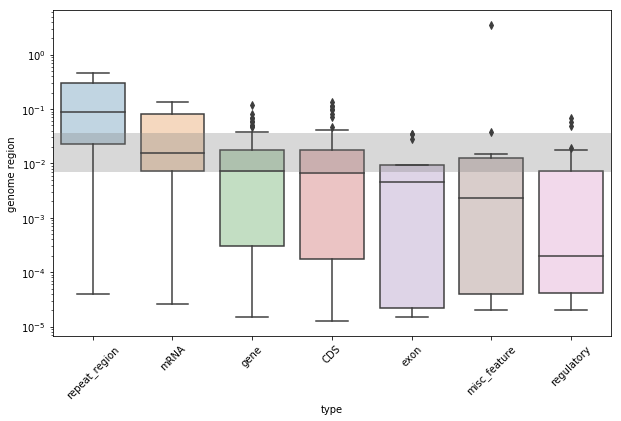

In [1461]:
ok = res3.type[~res3['Mean Rho/bp.'].isnull()].value_counts()
ok = ok[ok>=10].index
filter_data = res3[res3.type.isin(ok)]
mm = filter_data.groupby(['type'])['Mean Rho/bp.'].median()
order =  mm.sort_values(ascending=False).index

ax = sns.boxplot(x ='type',y = 'Mean Rho/bp.', data = filter_data,order = order)
ax.set_yscale('log')



for item in ax.get_xticklabels():
    item.set_rotation(45)


for patch in ax.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .3))
    
    
x =ax.get_xticks() 
y,y_low,y_up = rrate.apply(mean_value_by_integration)
    

currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((np.min(x)-1,y_low), np.max(x)-np.min(x)+2,y_up-y_low, facecolor="grey",alpha = 0.3) )   
ax.set_ylabel('4Ne.r/bp')
ax.set_ylabel('genome region')
plt.tight_layout()
#plt.tight_layout()
#savefig('bla',dpi = 500)


In [1198]:
result_by_region = res3.copy()

In [1210]:
result_by_region.head()

,type,gene,Mean Rho/bp.,-95% CI,+95% CI,start,end,length,trimmed_st,trimmed_end,length_aln,gc
rango,,,,,,,,,,,,
"(6955, 7128)",misc_feature,LMP2,3.567325,0.263320,3.526180,6955,7128,173,7064,7237,173,0.572254
"(82607, 82694)",repeat_region,LMP2,0.463480,0.224340,0.634265,82607,82694,87,84102,84189,87,0.620690
"(82097, 82123)",repeat_region,LMP2,0.457779,0.255647,1.730553,82097,82123,26,83568,83594,26,0.653846
"(82123, 82201)",repeat_region,LMP2,0.355370,0.172202,0.716514,82123,82201,78,83594,83693,99,0.525641
"(82282, 82360)",repeat_region,LMP2,0.313305,0.150702,0.428909,82282,82360,78,83775,83853,78,0.525641


In [1263]:
gb = result_by_region.groupby(['type'])['Mean Rho/bp.']
counts = gb.apply(lambda x: np.sum(~x.isnull()))
total_counts = gb.apply(lambda x: x.shape[0])


rho_mean = gb.apply(lambda x: np.nanmean(x))
rho_median = gb.apply(lambda x: np.nanmedian(x))

#cuentas = counts[counts>=10]

gb = result_by_region.groupby(['type'])['gc']
mean_gc , std_gc = gb.apply(lambda x: np.nanmean(x)), gb.std()
median_gc = gb.apply(lambda x: np.nanmedian(x))


tabla = pd.concat([total_counts,counts,rho_mean,rho_median,mean_gc,std_gc,median_gc],1)
tabla.columns = ['total_counts','counts','mean_4Ne.r/bp','median_4Ne.r/bp','mean_gc','std_gc','median_gc']

tabla.applymap(lambda x: np.round(x,5)).sort_values(by=['median_4Ne.r/bp'],ascending = False)

,total_counts,counts,mean_4Ne.r/bp,median_4Ne.r/bp,mean_gc,std_gc,median_gc
type,,,,,,,
rep_origin,4,1,0.16930,0.16930,0.58117,0.09057,0.60109
variation,4,1,0.14924,0.14924,0.61749,0.05997,0.63017
repeat_region,39,14,0.16755,0.08715,0.67453,0.10502,0.66862
mat_peptide,2,1,0.03085,0.03085,0.55235,0.03133,0.55235
STS,3,2,0.02455,0.02455,0.56167,0.01076,0.56263
mRNA,24,19,0.03954,0.01563,0.56149,0.07416,0.55920
gene,151,89,0.01462,0.00721,0.43389,0.24838,0.54461
intron,4,4,0.01432,0.00684,0.51038,0.07568,0.52834
CDS,138,90,0.01687,0.00667,0.58737,0.09318,0.57191


In [455]:
tipo = 'gene'
rregion = result_by_region[result_by_region.type == tipo]
rregion = rregion[~rregion['Mean Rho/bp.'].isnull()]

#plt.scatter(rregion['gc'],rregion['Mean Rho/bp.'])
#x = np.log10(rregion['Mean Rho/bp.'])#.plot(kind = 'density')
#ax = sns.kdeplot(x,bw = 0.5)



In [456]:
rregion

,type,gene,Mean Rho/bp.,-95% CI,+95% CI,start,end,length,trimmed_st,trimmed_end,length_aln
rango,,,,,,,,,,,
"(86075, 89502)",gene,EBNA3C,0.212407,0.106554,0.359557,86075,89502,3427,87637,91451,3814
"(83064, 89502)",gene,EBNA3B,0.109489,0.059213,0.179934,83064,89502,6438,84564,91451,6887
"(93954, 95627)",gene,BRRF2,0.083904,0.056170,0.111954,93954,95627,1673,96067,97794,1727
"(89156, 89872)",gene,BZLF2,0.071971,0.008364,0.150016,89156,89872,716,91105,91821,716
"(82932, 82938)",gene,EBNA3A,0.070057,0.035809,0.639623,82932,82938,6,84430,84436,6
"(104407, 106792)",gene,BBLF2-BBLF3,0.063146,0.040042,0.134046,104407,106792,2385,106749,109168,2419
"(77278, 77763)",gene,BLLF2,0.053842,0.033743,0.079786,77278,77763,485,78604,79098,494
"(89837, 90906)",gene,BZLF1,0.050885,0.022486,0.080570,89837,90906,1069,91787,92886,1099
"(68490, 69903)",gene,BMRF2,0.049431,0.027342,0.078073,68490,69903,1413,69650,71140,1490


### Intronic Regions

In [274]:
res2[res2.Symbol == 'LMP1']

,GeneID,Symbol,Aliases,Mean Rho/bp.,-95% CI,+95% CI,start_position_on_the_genomic_accession,end_position_on_the_genomic_accession,trimmed_st,trimmed_end,length_aln,length
134,3783750,LMP1,HHV4_LMP-1,0.022961,0.008374,0.046633,166461.0,169055.0,169832,173941,4109,2594.0
135,17494204,LMP1,NaN,0.014884,0.007945,0.016790,169083.0,169088.0,173970,173975,5,5.0


In [271]:
res3[(res3.gene.isin(['LMP1']))].sort_index()

,type,gene,Mean Rho/bp.,-95% CI,+95% CI,start,end,length,trimmed_st,trimmed_end,length_aln
rango,,,,,,,,,,,
"(166460, 168507)",exon,LMP1,0.027822,0.009989,0.057969,166460,168507,2047,169831,173369,3538
"(166460, 169055)",gene,LMP1,0.022961,0.008374,0.046633,166460,169055,2595,169831,173941,4110
"(166482, 166488)",regulatory,LMP1,NaN,NaN,NaN,166482,166488,6,169853,169859,6
"(166486, 166492)",regulatory,LMP1,NaN,NaN,NaN,166486,166492,6,169857,169863,6
"(167701, 168507)",CDS,LMP1,0.033367,0.011965,0.069538,167701,168507,806,171898,173369,1471
"(168507, 168583)",intron,LMP1,0.005743,0.001430,0.007964,168507,168583,76,173369,173452,83
"(168583, 168670)",CDS,LMP1,0.007193,0.003232,0.008277,168583,168670,87,173452,173549,97
"(168583, 168670)",exon,LMP1,0.007193,0.003232,0.008277,168583,168670,87,173452,173549,97
"(168670, 168748)",intron,LMP1,0.007257,0.004657,0.008317,168670,168748,78,173549,173628,79


In [303]:
from IPython.display import display, HTML
gen = regul[regul['Mean Rho/bp.']<0.001].gene.values[13]
print gen
display(res2[res2.Symbol == gen])
res3[(res3.gene.isin([gen]))].sort_index()

BFLF1


,GeneID,Symbol,Aliases,Mean Rho/bp.,-95% CI,+95% CI,start_position_on_the_genomic_accession,end_position_on_the_genomic_accession,trimmed_st,trimmed_end,length_aln,length
38,3783697,BFLF1,NaN,0.000294,0.00001,0.001069,44660.0,46280.0,45133,46756,1623,1620.0
39,17494244,BFLF1,NaN,0.000028,0.00001,0.000323,46544.0,46549.0,47020,47025,5,5.0


,type,gene,Mean Rho/bp.,-95% CI,+95% CI,start,end,length,trimmed_st,trimmed_end,length_aln
rango,,,,,,,,,,,
"(44659, 46237)",CDS,BFLF1,0.000302,0.00001,0.001095,44659,46237,1578,45132,46710,1578
"(44659, 46280)",gene,BFLF1,0.000294,0.00001,0.001069,44659,46280,1621,45132,46756,1624
"(44787, 44793)",regulatory,BFLF1,NaN,NaN,NaN,44787,44793,6,45260,45266,6
"(46274, 46280)",regulatory,BFLF1,0.000031,0.00001,0.000229,46274,46280,6,46747,46756,9
"(46543, 46549)",regulatory,BFLF1,0.000028,0.00001,0.000323,46543,46549,6,47019,47025,6
"(46543, 46549)",gene,BFLF1,0.000028,0.00001,0.000323,46543,46549,6,47019,47025,6


In [263]:
pd.DataFrame([res3.type.value_counts(),res3.type[~res3['Mean Rho/bp.'].isnull()].value_counts()]).transpose()

,type,type
CDS,138,90
STS,3,2
exon,39,13
gene,151,89
intron,4,4
mRNA,24,19
mat_peptide,2,1
misc_RNA,3,3
misc_feature,51,10
ncRNA,3,2


In [525]:
res3.type.value_counts()

gene             151
CDS              138
regulatory       125
misc_feature      51
exon              39
repeat_region     39
mRNA              24
intron             4
variation          4
rep_origin         4
misc_RNA           3
ncRNA              3
STS                3
mat_peptide        2
Name: type, dtype: int64

In [1110]:
res3.sort_index().head(40).tail(10)

,type,gene,Mean Rho/bp.,-95% CI,+95% CI,start,end,length,trimmed_st,trimmed_end,length_aln
rango,,,,,,,,,,,
"(7314, 9312)",rep_origin,LMP2,0.1693,0.064088,0.947908,7314,9312,1998,7424,9511,2087
"(7420, 8042)",repeat_region,LMP2,NaN,NaN,NaN,7420,8042,622,7531,8193,662
"(9020, 9133)",misc_feature,LMP2,NaN,NaN,NaN,9020,9133,113,9217,9330,113
"(9630, 9636)",regulatory,BCRF1,NaN,NaN,NaN,9630,9636,6,9831,9837,6
"(9630, 10262)",gene,BCRF1,NaN,NaN,NaN,9630,10262,632,9831,10464,633
"(9674, 10187)",CDS,BCRF1,NaN,NaN,NaN,9674,10187,513,9875,10388,513
"(10256, 10262)",regulatory,BCRF1,NaN,NaN,NaN,10256,10262,6,10458,10464,6
"(11304, 11308)",regulatory,BCR2,NaN,NaN,NaN,11304,11308,4,11522,11525,3
"(11304, 11308)",gene,BCR2,NaN,NaN,NaN,11304,11308,4,11522,11525,3


In [1474]:
def complete_features(seq_record_genbank, TIPO='regulatory',n=5 ):
    #rates = res3[res3.type == TIPO]
    #rates = rates[~rates['Mean Rho/bp.'].isnull()]

    ttyp = []
    loc = []
    get = []
    pos = []
    for feature in seq_record.features:
        ttyp.append(feature.type)

        if TIPO[0:n] in feature.type:
            get.append({k: feature.qualifiers[k][0] for k in feature.qualifiers.keys()})

            partes = []
            for p in feature.location.parts:
                partes.append(pd.Series([p.start.position,p.end.position]))
            positions = pd.concat(partes,1).transpose()    
            positions.columns = ['start','end']
            pos.append(positions)        #print feature

    get = pd.DataFrame(get)        
    pos = pd.concat(pos)

#    return(get,pos)

    pos.index = get.index
    get_features = pd.concat([get,pos],1)
        
    #rho = rates[['gene','Mean Rho/bp.','start']]#'+95% CI','start','end']]
    #rho = pd.merge(rho,get_features.drop(['gene'],1),on='start',how = 'outer')
    return(get_features)

In [759]:
seq_record = SeqIO.read()

type: repeat_region
location: [7420:8042](+)
qualifiers:
    Key: gene, Value: ['LMP2']
    Key: note, Value: ['binding sites for EBNA-1 (site I); tandem repeat part of oriP; also functions as a cell type specific enhancer']
    Key: rpt_unit_range, Value: ['7421..7450']



In [ ]:
tipo = 'repeat_region'
repeat_region = complete_features(tipo,n=len(tipo))

_, ncbi_repeat_rates = mapp_and_compute_rho(repeat_region,start_col = 'start')

ncbi_repeat_rates['call'] = ncbi_repeat_rates['rpt_type'].fillna('') + ncbi_repeat_rates['rpt_family'].fillna('')
ncbi_repeat_rates.sort_values(['Mean Rho/bp.

In [ ]:
tipo = 'repeat_region'
repeat_region = complete_features(tipo,n=len(tipo))

_, ncbi_repeat_rates = mapp_and_compute_rho(repeat_region,start_col = 'start')

ncbi_repeat_rates['call'] = ncbi_repeat_rates['rpt_type'].fillna('') + ncbi_repeat_rates['rpt_family'].fillna('')
ncbi_repeat_rates.sort_values(['Mean Rho/bp.'],ascending = False)

In [1485]:
tipo = 'repeat_region'
repeat_region = complete_features(tipo,n=len(tipo))

_, ncbi_repeat_rates = mapp_and_compute_rho(repeat_region,start_col = 'start')

ncbi_repeat_rates['call'] = ncbi_repeat_rates['rpt_type'].fillna('') + ncbi_repeat_rates['rpt_family'].fillna('')
ncbi_repeat_rates.sort_values(['Mean Rho/bp.'],ascending = False)

,gene,locus_tag,note,rpt_family,rpt_type,rpt_unit_range,start,end,trimmed_st,trimmed_end,Mean Rho/bp.,-95% CI,+95% CI,call
25,LMP2,NaN,NaN,type D,NaN,NaN,82607,82694,84102,84189,0.463480,0.224340,0.634265,type D
20,LMP2,NaN,NaN,type B,NaN,NaN,82097,82123,83568,83594,0.418404,0.232529,1.591287,type B
21,LMP2,NaN,NaN,type C,NaN,NaN,82123,82201,83594,83693,0.364120,0.177834,0.697887,type C
23,LMP2,NaN,NaN,type C,NaN,NaN,82282,82360,83775,83853,0.333231,0.160409,0.455931,type C
19,LMP2,NaN,NaN,type C,NaN,NaN,82018,82093,83488,83564,0.244155,0.091918,0.605111,type C
18,LMP2,NaN,NaN,type B,NaN,NaN,81992,82018,83462,83488,0.208978,0.035309,0.285293,type B
22,LMP2,NaN,NaN,type A,NaN,NaN,82201,82272,83693,83765,0.112942,0.052186,0.153910,type A
24,LMP2,NaN,NaN,type A,NaN,NaN,82360,82431,83853,83926,0.049668,0.023083,0.069421,type A
17,LMP2,NaN,NaN,type A,NaN,NaN,81919,81989,83389,83459,0.041058,0.027797,0.051768,type A
28,EBNA3C,NaN,NaN,NaN,NaN,87834..87848,87833,88016,89561,89747,0.040180,0.000970,0.045490,


In [586]:
tipo = 'regulatory'
regulatory = complete_features(tipo,n=len(tipo))
regulatory.head(2)

,gene,Mean Rho/bp.,start,gene_synonym,locus_tag,note,regulatory_class,end
0,BZLF2,0.068269,89866,NaN,HHV4_BZLF2,NaN,TATA_box,89872
1,EBNA3A,0.058441,82932,NaN,NaN,NaN,polyA_signal_sequence,82938


In [587]:
regulatory.groupby(['regulatory_class'])['Mean Rho/bp.'].mean()

regulatory_class
TATA_box                 0.008578
polyA_signal_sequence    0.007909
Name: Mean Rho/bp., dtype: float64

### REPEAT MOTIFS

In [904]:
from Bio.Seq import Seq
import re

def search_fasta(pattern, file_path):
    st = []
    end = []
    pat =[]
    reverse = str(Seq(pattern).reverse_complement())
    
    for patt in [pattern,reverse]:
        for record in SeqIO.parse(open(file_path, "rU"), "fasta"):
            chrom = record.id
            for match in re.finditer(patt, str(record.seq)):
                start_pos = match.start() + 1
                end_pos = match.end() + 1
                st.append(start_pos)
                end.append(end_pos)
                pat.append(patt)
    df = pd.DataFrame({'st':st,'end':end,'pattern':pat,'call':pattern})
    df = df[['st','end','pattern','call']]
    df.sort_values(by=['st'],inplace = True)
    
    return(df)





In [922]:
brown_repeats = ['TGGTGG','CCTCCCCT','TGGAG','AGGAG','CCCAG','GGGCT']
file_path = '/data/EBV/byACCIDs/NC_007605.fasta'


positions = {}
for br_rep in brown_repeats:
    df = search_fasta(br_rep,file_path)
    positions.update({br_rep:df})
    
repeat_postions = pd.concat(positions)
gb = pd.concat(positions).groupby(['call'])

gb.apply(lambda x: x.shape[0])

call
AGGAG        745
CCCAG       1032
CCTCCCCT      28
GGGCT        713
TGGAG        697
TGGTGG       252
dtype: int64

In [923]:
repeat_postions.head()

st  end pattern   call
AGGAG 404  352  357   CTCCT  AGGAG
      405  557  562   CTCCT  AGGAG
      0    578  583   AGGAG  AGGAG
      406  671  676   CTCCT  AGGAG
      407  936  941   CTCCT  AGGAG

In [1013]:
def mapp_and_compute_rho(df,start_col = 'st',end_col = 'end'):
    df = df.dropna(subset=[start_col,end_col])
    start_aux = [x if x in mapp_dict.keys() else (x +1 ) for x in df[start_col].values]
    end_aux = [x if x in mapp_dict.keys() else (x -1 ) for x in df[end_col].values]


    df['trimmed_st'] = get_items(mapp_dict,start_aux)
    df['trimmed_end'] = get_items(mapp_dict,end_aux)

    computed_rates = df.apply(lambda x: pd.concat([x,compute_local_obs(rrate,r1 = x.trimmed_st,r2 = x.trimmed_end)]),axis =1)
    return df,computed_rates

In [1462]:
rrate.head()

,Mean Rho/bp.,-95% CI,+95% CI
trimmed_position,,,
1.0,0.00001,0.00001,0.00001
3.0,0.00001,0.00001,0.00001
8.0,0.00001,0.00001,0.00001
10.0,0.00001,0.00001,0.00001
12.0,0.00001,0.00001,0.00001


In [1469]:
#repeat_rates = df.apply(lambda x: pd.concat([x,compute_local_obs(rrate,r1 = x.trimmed_st,r2 = x.trimmed_end)]),axis =1)

brown_repeats = ['TGGTGG','CCTCCCCT','TGGAG','AGGAG','CCCAG','GGGCT']
file_path = '/data/EBV/byACCIDs/NC_007605.fasta'


positions = {}
for br_rep in brown_repeats:
    df = search_fasta(br_rep,file_path)
    positions.update({br_rep:df})
    
repeat_postions = pd.concat(positions)


_, motifs_rates = mapp_and_compute_rho(repeat_postions)
#repeat_rates.groupby(['call'])['Mean Rho/bp.'].apply(lambda x: np.nanmean(x))                    


In [1470]:
motifs_rates.head()

st  end pattern   call  trimmed_st  trimmed_end  Mean Rho/bp.  \
AGGAG 404  352  357   CTCCT  AGGAG         352          357      0.000022   
      405  557  562   CTCCT  AGGAG         557          562      0.000018   
      0    578  583   AGGAG  AGGAG         578          582      0.000016   
      406  671  676   CTCCT  AGGAG         671          676           NaN   
      407  936  941   CTCCT  AGGAG         936          941           NaN   

           -95% CI   +95% CI  
AGGAG 404  0.00001  0.000158  
      405  0.00001  0.000097  
      0    0.00001  0.000090  
      406      NaN       NaN  
      407      NaN       NaN

In [939]:
print repeat_rates.shape
print repeat_rates.dropna().shape

(3467, 9)
(864, 9)


# fraccion de nulos en cada repeat type

In [943]:
repeat_rates.groupby('call').apply(lambda x: x['Mean Rho/bp.'].isnull().sum()/float(len(x['Mean Rho/bp.'])))

call
AGGAG       0.754362
CCCAG       0.784884
CCTCCCCT    0.642857
GGGCT       0.785414
TGGAG       0.694405
TGGTGG      0.670635
dtype: float64

In [1017]:
inverted = pd.read_csv('/data/EBV/repeat_regions/inverted_positions_with_complemented.txt',header = None,sep = '\t')
inv = pd.concat([inverted.iloc[:,1].str.split('>NC_007605.1_').apply(lambda x: (x[1].split('_')[0])),
                inverted.iloc[:,1].str.split('>NC_007605.1_').apply(lambda x: (x[1].split('_')[1]))],1)
inv.columns = ['st','end']
inv['st'] = pd.to_numeric(inv['st']) 
inv['end'] = pd.to_numeric(inv['end']) 

df = inv.copy()

df2, inverted_rates =  mapp_and_compute_rho(df=df,start_col = 'st',end_col = 'end')


In [1031]:
i = 0
s = df2.iloc[i,:].trimmed_st
e =df2.iloc[i,:].trimmed_end
print s,e
rrate.loc[s:25000.0].head()

7562 7842


,Mean Rho/bp.,-95% CI,+95% CI
trimmed_position,,,
24818.0,0.00056,0.0005,0.00062


In [1055]:
rrate.head()

,Mean Rho/bp.,-95% CI,+95% CI
trimmed_position,,,
1.0,0.00001,0.00001,0.00001
3.0,0.00001,0.00001,0.00001
8.0,0.00001,0.00001,0.00001
10.0,0.00001,0.00001,0.00001
12.0,0.00001,0.00001,0.00001


In [3]:
rrates_reference = pd.merge(mapp[['refCoord','trimmedCoord']],rrate.reset_index(),how='inner',left_on='trimmedCoord',right_on='trimmed_position')
rrates_reference.head()
rrates_reference.set_index(['refCoord'],inplace = True)
rrates_reference.drop(['trimmedCoord','trimmed_position'],1,inplace = True)
rrates_reference['Mean Rho/bp.'].plot()

NameError: name 'mapp' is not defined

In [1072]:
rrates_reference.reset_index().refCoord.max()

170729

Populating the interactive namespace from numpy and matplotlib


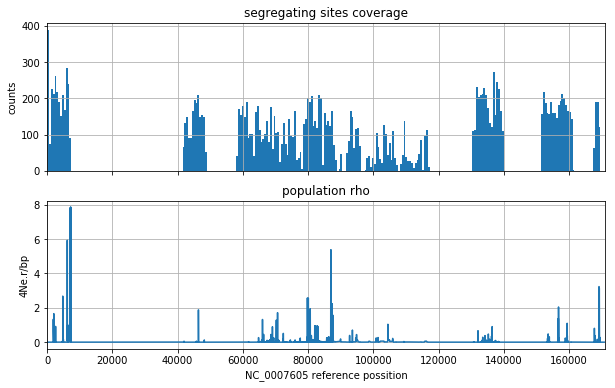

In [373]:
rrates_reference = pd.merge(mapp[['refCoord','trimmedCoord']],rrate.reset_index(),how='inner',left_on='trimmedCoord',right_on='trimmed_position')
rrates_reference.head()
rrates_reference.set_index(['refCoord'],inplace = True)
rrates_reference.drop(['trimmedCoord','trimmed_position'],1,inplace = True)
rrates_reference['Mean Rho/bp.'].plot()

%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.hist(rrates_reference.reset_index().refCoord,bins = 300)
ax1.set_xlim([0,171000])
ax1.set_title('segregating sites coverage')
ax1.set_ylabel('counts')
ax1.grid()

ax2.plot(rrates_reference['Mean Rho/bp.'])
#ax2.set_yscale('log')

ax2.set_xlabel('NC_0007605 reference possition')
ax2.set_title('population rho')
ax2.set_ylabel('4Ne.r/bp')
ax2.grid()

,st,end,trimmed_st,trimmed_end
0,7451,7708,7562,7842
1,7747,8004,7892,8149
2,9019,9049,9216,9246
3,9053,9083,9250,9280
4,12404,12557,12621,12774


In [1468]:
tandem = pd.read_csv('/data/EBV/repeat_regions/tandem_table.csv',sep =',')
tandem.columns = ['st','end']
_ , tandem_rates = mapp_and_compute_rho(tandem)
#display(tandem_rates)

## Protein functions

In [585]:
prot = pd.read_table('/data/EBV/proteome/uniprot-database%3A%28type%3Aembl+AJ507799%29.tab')
prot.columns

Index([u'Entry', u'Entry name', u'Status', u'Protein names', u'Gene names',
       u'Organism', u'Length', u'Keywords', u'Sequence', u'Version (sequence)',
       u'Fragment', u'Gene ontology (biological process)',
       u'Gene ontology (cellular component)',
       u'Gene ontology (molecular function)', u'Gene ontology IDs'],
      dtype='object')

In [607]:
prot['genes'] = prot['Gene names'].str.split(' ',1)

In [663]:
maps = {}
for g in regulatory.gene.values:
    ind = np.where([g in pg for pg in prot.genes.values])[0]
    if len(ind) !=0:
        ind = ind[0]
        maps.update({g:ind})
maps = pd.Series(maps)

In [668]:
high = regulatory[regulatory['Mean Rho/bp.']>=0.001].gene
low = regulatory[regulatory['Mean Rho/bp.']<0.001].gene

In [740]:
def get_go(dfprot):
    GOs = []
    goes = (dfprot['Gene ontology IDs']).str.split(';')
    goes.dropna(inplace = True)
#    print goes
    for lgo in goes:
        for go in lgo:
            gs = go.replace(" ", "") 
            GOs.append(gs)
    return(pd.Series(GOs).value_counts())


auxmap = maps[high].dropna()
dfprot_high_reg = prot.iloc[auxmap.values]
go_high_regulation = get_go(dfprot_high_reg)

auxmap = maps[low].dropna()
dfprot_low_reg = prot.iloc[auxmap.values]
go_low_regulation = get_go(dfprot_low_reg)


In [744]:
go_high_regulation.head()

GO:0042025    5
GO:0016021    4
GO:0046718    3
GO:0019033    3
GO:0019076    2
dtype: int64

In [743]:
go_low_regulation.head()

GO:0042025    5
GO:0016021    5
GO:0020002    4
GO:0030430    4
GO:0019031    4
dtype: int64

In [747]:
go_high_regulation['GO:0020002']

2

In [104]:
res3.groupby(['type','gene'])['length','Mean Rho/bp.','-95% CI','+95% CI'].mean()/rho_mean

length  \
type          gene                                                        
CDS           A73                                           4990.468387   
              BALF1                                        34736.803576   
              BALF2                                       177456.340440   
              BALF3                                       124172.284276   
              BALF4                                       134860.531530   
              BALF5                                       159694.988385   
              BARF0                                        74189.010352   
              BARF1                                        34893.983683   
              BBLF1                                        11945.688108   
              BBLF2-BBLF3                                  56899.198617   
              BBLF4                                       127315.886409   
              BBRF2                                        43853.249763   
              BBRF3                                        63815.123311   
              BCRF1                                        26877.798242   
              BCRF2                                        60357.160964   
              BDLF1                                        47468.392217   
              BDLF2                                        66172.824911   
              BDLF3                                        36937.325069   
              BDLF4                                        35522.704109   
              BFLF1                                        82676.736113   
              BFLF2                                        50140.454030   
              BFRF1                                        52969.695951   
              BFRF1A                                       21376.494508   
              BFRF2                                        93050.623153   
              BFRF3                                        27820.878882   
              BGLF1                                        79847.494192   
              BGLF2                                        52969.695951   
              BGLF3                                        52340.975524   
              BGLF3.5                                      24205.736428   
              BGLF4                                        67587.445872   
...                                                                 ...   
regulatory    BZLF2                                          314.360213   
              BaRF1                                          314.360213   
              BcLF1                                          314.360213   
              BcRF1                                          314.360213   
              BdRF1                                          314.360213   
              EBNA-1                                         314.360213   
              EBNA-2                                         314.360213   
              EBNA-3C                                        314.360213   
              EBNA-LP                                         52.393369   
              EBNA3A                                         314.360213   
              LMP1                                           314.360213   
              LMP2                                           314.360213   
              LMP2A                                          314.360213   
              None                                           314.360213   
              RPMS1                                          314.360213   
              RPMS1 and A73 RNAs                             314.360213   
              SM                                             314.360213   
              lytic LMP1                                     314.360213   
              possible start for 2kb RNAs crossing BILF2     314.360213   
rep_origin    LMP2                                         58453.535228   
              RPMS1                                        64862.990689   
repeat_region B

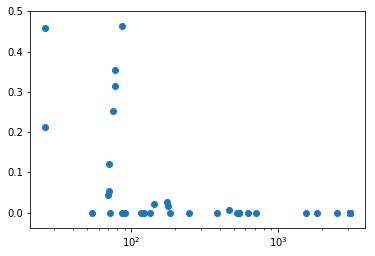

In [113]:
aux = res3[res3.type == 'repeat_region'].copy()
aux.fillna(0,inplace = True)
plt.scatter(aux['length'],aux['Mean Rho/bp.'])
plt.xscale('log')

In [ ]:
## lock for sts 
## compute gc content and correlate it with recombination rate. 


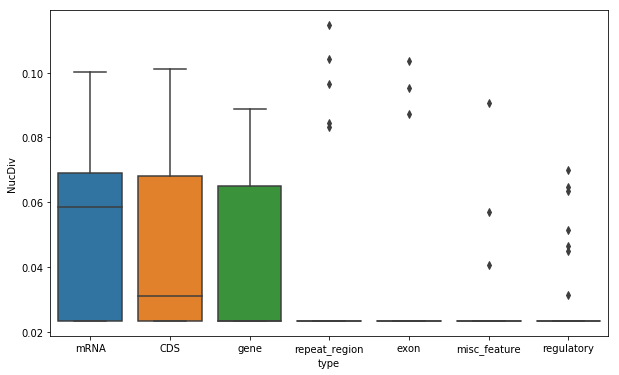

In [1302]:
order =  mm.sort_values(ascending=False).index
ax = sns.boxplot(x ='type',y = 'NucDiv', data = filter_data,order = order)

#ax.set_yscale('log')

In [1307]:
nd_regions.columns

Index([u'type', u'gene', u'Mean.Rho.bp.', u'X.95..CI', u'X.95..CI.1', u'start',
       u'end', u'length', u'trimmed_st', u'trimmed_end', u'length_aln', u'GC',
       u'NucDiv'],
      dtype='object')

In [1402]:
from outliers import smirnov_grubbs as grubbs
gb = filter_data.groupby(['type'])['Mean.Rho.bp.']
outliers_by_region=gb.apply(lambda x: grubbs.max_test_outliers(x.dropna(), alpha=0.00001))

outl = [item for sublist in outliers_by_region for item in sublist]


In [1403]:
outliers_by_region

type
CDS              [0.251431168532]
exon                           []
gene             [0.212406947187]
mRNA                           []
misc_feature            [3.90529]
regulatory                     []
repeat_region                  []
Name: Mean.Rho.bp., dtype: object

In [1420]:
gene_coords[gene_coords.Symbol=='LMP1']

,tax_id,Org_name,GeneID,CurrentID,Status,Symbol,Aliases,description,other_designations,map_location,chromosome,genomic_nucleotide_accession.version,start_position_on_the_genomic_accession,end_position_on_the_genomic_accession,orientation,exon_count,OMIM,Unnamed: 17
134,10376,Human herpesvirus 4,3783750,0,live,LMP1,HHV4_LMP-1,LMP1,LMP1|hypothetical protein,NaN,NaN,NC_007605.1,166461.0,169055.0,minus,0.0,NaN,NaN
135,10376,Human herpesvirus 4,17494204,0,live,LMP1,NaN,NaN,NaN,NaN,NaN,NC_007605.1,169083.0,169088.0,minus,0.0,NaN,NaN


In [1454]:
f = '/home/ariel/Projects/Gutierrez/EBV-recomb/recomb/rdp4_results/ids_171_ebv/10Miter/results/result_by_region_10Miters.csv_with_ndiv.csv'
nd_regions = pd.read_csv(f,sep=',')
ok = nd_regions.type[~nd_regions['Mean.Rho.bp.'].isnull()].value_counts()
ok = ok[ok>=10].index
filter_data = nd_regions[nd_regions.type.isin(ok)].copy()

# fill na 
mmin = filter_data.NucDiv.min()
filter_data.NucDiv.fillna(mmin,inplace = True)

################# outliers by region ##################
outliersByReg = []
for ty in outliers_by_region.index:
    ii = filter_data[(filter_data.type==ty)&(filter_data['Mean.Rho.bp.'].isin(outliers_by_region[ty]))].index.values
    if len(ii)>0:
        outliersByReg.append(ii[0])

outlier_data = filter_data.loc[outliersByReg,] 
        
filter_data = filter_data.drop(outliersByReg)        

import numpy as np, scipy.stats as st
def standerr(a):
    return(st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a)))

    
mm = filter_data.groupby(['type'])[['NucDiv','GC','Mean.Rho.bp.', u'X.95..CI', u'X.95..CI.1','length']].mean()
mstd = filter_data.groupby(['type'])[['NucDiv','GC','length']]

mstd.apply(lambda x: confIntMean(x))
#mstd.columns = ['std-nt','std-GC','std-legth']
#mstd
#mm = pd.merge(mm,mstd,left_index=True,right_index=True,how = 'inner')

#mm.sort_values(by='Mean.Rho.bp.',ascending = False)

#outlier_data.to_csv(outpath+'dropped_outliers.csv')
#mm.to_csv(outpath+'table_GC_NTdiv_rho.csv')

type
CDS              1.977561
exon             2.024394
gene             1.976013
mRNA             2.068658
misc_feature     2.009575
regulatory       1.979280
repeat_region    2.024394
dtype: float64

In [1458]:
?st.sem

In [1457]:

st.t.ppf((1+0.95)/2., len(x)-1)

2.0095752344892088

In [1453]:
import numpy as np, scipy.stats as st

# returns confidence interval of mean
def confIntMean(a, conf=0.95):
    mean, sem, m = np.mean(a), st.sem(a), st.t.ppf((1+conf)/2., len(a)-1)
    #return mean - m*sem, mean + m*sem
    return(m)

In [1449]:
x = filter_data[filter_data.type=='misc_feature']['length']
standerr(x)

(-141.26282197627415, 1189.3028219762741)

In [1269]:
msa = AlignIO.read('/data/EBV/msas/ids_171_ebv/ids_171_ebv_msa_gap1.51_trimmed0.05.fas_1_60000.fa','fasta')
msa[:,0]

'-aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa-aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa-aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaagaaaaaaaaaaaaaaaaaaa-'

In [ ]:
def nt_diversity(align):
    gs = seq.count('G')
    cs = seq.count('C')
    return (gs+cs)/float(len(seq))

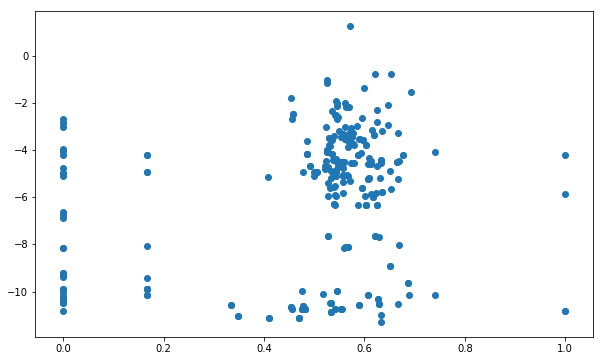

In [1136]:
aux = res3[~res3['Mean Rho/bp.'].isnull()]
plt.scatter(aux.gc,np.log(aux['Mean Rho/bp.']))
#np.min(aux['Mean Rho/bp.'])


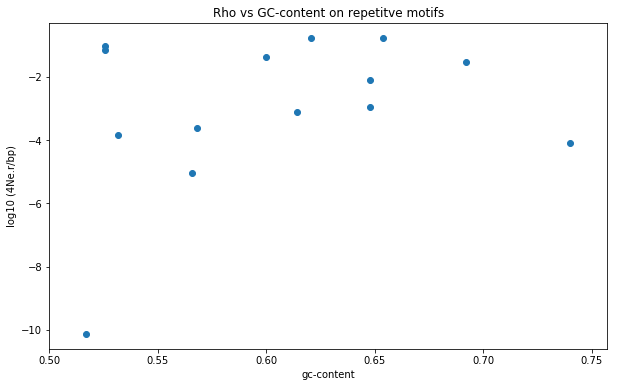

In [1141]:
#### TIPO = 'repeat_region'
aux = res3[~res3['Mean Rho/bp.'].isnull()]
aux = aux[aux.type==TIPO]
plt.scatter(aux.gc,np.log(aux['Mean Rho/bp.']))
plt.ylabel('log10 (4Ne.r/bp)')
plt.xlabel('gc-content')
plt.title('Rho vs GC-content on repetitve motifs')



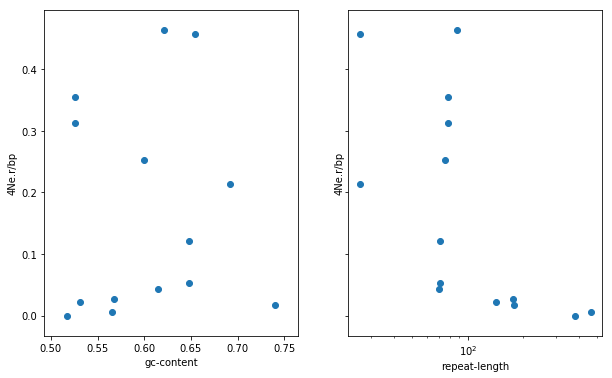

In [1151]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

aux = res3[res3.type == 'repeat_region'].copy()
#aux.fillna(0,inplace = True)




ax1.scatter(aux['length'],aux['Mean Rho/bp.'])
ax1.set_xscale('log')
ax1.set_xlabel('repeat-length')
ax1.set_ylabel('4Ne.r/bp')


ax2.scatter(aux['gc'],aux['Mean Rho/bp.'])
ax2.set_xlabel('gc-content')
ax2.set_ylabel('4Ne.r/bp')





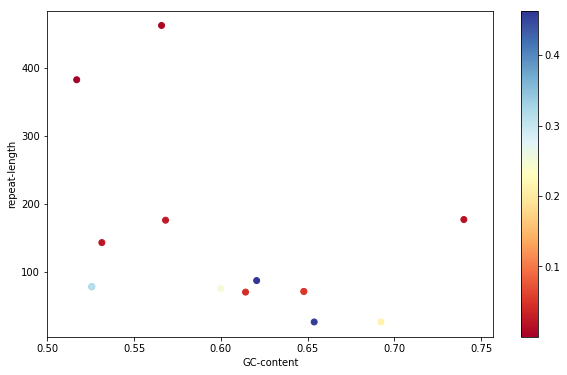

In [1164]:
cm = plt.cm.get_cmap('RdYlBu')
color = aux['Mean Rho/bp.'].values
fig = plt.scatter(aux['gc'],aux['length'],c=color, cmap=cm)
plt.colorbar(fig)
#plt.yscale('log')
plt.ylabel('repeat-length')
plt.xlabel('GC-content')

#

In [1491]:
dfrep = pd.read_csv('/home/ariel/Projects/Gutierrez/EBV-recomb/recomb/rdp4_results/ids_171_ebv/10Miter/results/repeats_analysis.csv')

In [1526]:
print dfrep.shape
def nonnan(x):
    return((~x.isnull()).sum())

repg1 = dfrep.groupby(['call'])[['Mean Rho/bp.','+95% CI','-95% CI']]
repg2 = dfrep.groupby(['call'])['Mean Rho/bp.']

a =repg1.agg({'mean':np.nanmean})
b = repg2.agg({'motifs':len,'signal':nonnan})
c = pd.concat([a,b],1)
c['prob'] = c['signal']/c['motifs']
#c.sort_values(by=["(u'mean', u'Mean Rho/bp.'])
c.sort_values(by=[('mean', 'Mean Rho/bp.')],ascending = False)

(3549, 15)


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


,"(mean, Mean Rho/bp.)","(mean, +95% CI)","(mean, -95% CI)",signal,motifs,prob
call,,,,,,
type D,0.465500,0.632640,0.303605,1.0,2.0,0.500000
type C,0.304569,0.410487,0.200065,3.0,3.0,1.000000
type B,0.283990,0.386150,0.175771,2.0,2.0,1.000000
CCTCCCCT,0.113380,0.224985,0.052332,10.0,28.0,0.357143
type A,0.068306,0.089276,0.047678,3.0,3.0,1.000000
AGGAG,0.037662,0.066292,0.024353,183.0,745.0,0.245638
CCCAG,0.033701,0.043993,0.024194,222.0,1032.0,0.215116
TGGAG,0.029070,0.035976,0.017308,213.0,697.0,0.305595
GGGCT,0.022903,0.037323,0.015299,153.0,713.0,0.214586


In [1529]:
dfrep.call.value_counts()

CCCAG                              1032
AGGAG                               745
GGGCT                               713
TGGAG                               697
TGGTGG                              252
CCTCCCCT                             28
inverted                             24
tandem                               19
TERMINAL                              4
type A                                3
type C                                3
type B                                2
type D                                2
EBNA triplet repeat GGA,GCA,GGG       1
PstI repeats                          1
Name: call, dtype: int64

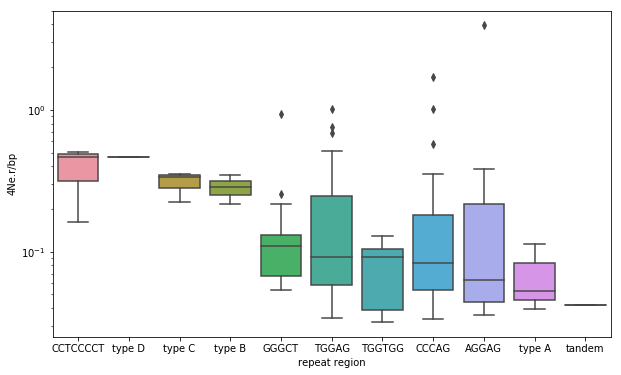

In [1561]:
outpath = '/home/ariel/Projects/Gutierrez/EBV-recomb/recomb/rdp4_results/ids_171_ebv/10Miter/results/'
whole_repeats = pd.read_csv(outpath+'repeats_analysis.csv')
thr = np.nanmean(whole_repeats['Mean Rho/bp.'])
aux = whole_repeats[whole_repeats['Mean Rho/bp.']>thr].copy()

order =  aux.groupby(['call'])['Mean Rho/bp.'].apply(lambda x:np.median(x)).sort_values(ascending=False).index
ax = sns.boxplot(x ='call',y = 'Mean Rho/bp.', data = aux,order = order)
ax.set_yscale('log')
ax.set_xlabel('repeat region')
ax.set_ylabel('4Ne.r/bp')
plt.savefig(outpath+'boxplot_repetitive_regions'+'.png',dpi = 500)


In [1501]:
dfrep[['Mean Rho/bp.','+95% CI','-95% CI']].apply(lambda x: np.nanmean(x))

Mean Rho/bp.    0.031926
+95% CI         0.049630
-95% CI         0.020713
dtype: float64

In [1489]:
dfrep.drop(['locus_tag','note','rpt_family','rpt_type'],inplace = True,axis = 1)

In [1549]:
dfrep[dfrep['call'].isin(['type A','type B','type C','type D'])].head(20)

,+95% CI,-95% CI,Mean Rho/bp.,call,end,gene,locus_tag,note,pattern,rpt_family,rpt_type,rpt_unit_range,st,trimmed_end,trimmed_st
3527,0.047268,0.031879,0.039373,type A,81989.0,LMP2,NaN,NaN,NaN,type A,NaN,NaN,81919.0,83459.0,83389.0
3528,0.301226,0.121361,0.218319,type B,82018.0,LMP2,NaN,NaN,NaN,type B,NaN,NaN,81992.0,83488.0,83462.0
3529,0.299366,0.147257,0.222679,type C,82093.0,LMP2,NaN,NaN,NaN,type C,NaN,NaN,82018.0,83564.0,83488.0
3530,0.471074,0.230180,0.349661,type B,82123.0,LMP2,NaN,NaN,NaN,type B,NaN,NaN,82097.0,83594.0,83568.0
3531,0.478135,0.232321,0.354479,type C,82201.0,LMP2,NaN,NaN,NaN,type C,NaN,NaN,82123.0,83693.0,83594.0
3532,0.151219,0.075237,0.113003,type A,82272.0,LMP2,NaN,NaN,NaN,type A,NaN,NaN,82201.0,83765.0,83693.0
3533,0.453959,0.220618,0.336549,type C,82360.0,LMP2,NaN,NaN,NaN,type C,NaN,NaN,82282.0,83853.0,83775.0
3534,0.069342,0.035917,0.052543,type A,82431.0,LMP2,NaN,NaN,NaN,type A,NaN,NaN,82360.0,83926.0,83853.0
3535,0.632640,0.303605,0.465500,type D,82694.0,LMP2,NaN,NaN,NaN,type D,NaN,NaN,82607.0,84189.0,84102.0
3536,NaN,NaN,NaN,type D,82781.0,LMP2,NaN,NaN,NaN,type D,NaN,NaN,82694.0,84279.0,84189.0


In [1562]:
#aux = dfrep[dfrep['Mean Rho/bp.']>0.02].copy()
#aux.set_index(['st'],inplace = True)
#aux.sort_index(inplace = True)
#aux[aux.index>83000]

In [1566]:
#dfrep[dfrep.call.isin(['type A','type B','type C','type D',])]

In [1568]:
st = 'start_position_on_the_genomic_accession'
end = 'end_position_on_the_genomic_accession'

In [1604]:
gene_coords[st].isnull().sum()

1

In [1610]:
aux = gene_coords[~gene_coords[st].isnull()].copy()


In [1634]:
gene_coords.columns

Index([u'tax_id', u'Org_name', u'GeneID', u'CurrentID', u'Status', u'Symbol',
       u'Aliases', u'description', u'other_designations', u'map_location',
       u'chromosome', u'genomic_nucleotide_accession.version',
       u'start_position_on_the_genomic_accession',
       u'end_position_on_the_genomic_accession', u'orientation', u'exon_count',
       u'OMIM', u'Unnamed: 17', u'range'],
      dtype='object')

array(['EBNA3B', 'EBNA3C'], dtype=object)

In [1639]:
gene_coords[gene_coords.Symbol=='LMP2'].

,tax_id,Org_name,GeneID,CurrentID,Status,Symbol,Aliases,description,other_designations,map_location,chromosome,genomic_nucleotide_accession.version,start_position_on_the_genomic_accession,end_position_on_the_genomic_accession,orientation,exon_count,OMIM,Unnamed: 17,range
rang,,,,,,,,,,,,,,,,,,,
"(58.0, 166458.0)",10376,Human herpesvirus 4,17494212,0,live,LMP2,NaN,EBNA3A nuclear protein,BGRF1-BDRF1 protein|putative DNA packaging pro...,NaN,NaN,NC_007605.1,58.0,166458.0,plus,0.0,NaN,NaN,"(58.0, 166458.0)"


In [1644]:
np.unique(['A','B','A'])

array(['A', 'B'],
      dtype='|S1')

In [1687]:
len(refs)

3549

SyntaxError: invalid syntax (<ipython-input-1-90bf49aa3bea>, line 15)

# PREPARE FIGURE ANALYSIS FOR GENES

In [141]:
import pandas as pd
import numpy as np
gene_coords_file = '/data/EBV/by_gene/gene_result.txt'
repeats_analysis_file = '/home/ariel/Projects/Gutierrez/EBV-recomb/recomb/rdp4_results/ids_171_ebv/10Miter/results/repeats_analysis.csv'
dfrep = pd.read_csv(repeats_analysis_file)

gene_coords = pd.read_csv(gene_coords_file,sep = '\t')
gene_ref_coords = gene_coords[['GeneID','Symbol','Aliases','start_position_on_the_genomic_accession','end_position_on_the_genomic_accession']]
gene_ref_coords['rang'] = gene_coords.apply(lambda x: (x.start_position_on_the_genomic_accession,
                                                   x.end_position_on_the_genomic_accession),1)
gene_ref_coords.set_index(['rang'],inplace = True)

def look_for_gene(position,gene_coords):
    res = gene_coords[(position> gene_coords.start_position_on_the_genomic_accession) & (position<gene_coords.end_position_on_the_genomic_accession)]
    return(res.Symbol.unique())

start_col = 'start_position_on_the_genomic_accession'
end_col = 'end_position_on_the_genomic_accession'


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [142]:
dfrep.head()

,+95% CI,-95% CI,Mean Rho/bp.,call,end,gene,locus_tag,note,rpt_family,rpt_type,rpt_unit_range,st,trimmed_end,trimmed_st
0,NaN,NaN,NaN,inverted,7708.0,NaN,NaN,NaN,NaN,NaN,NaN,7451.0,7842.0,7562.0
1,NaN,NaN,NaN,inverted,8004.0,NaN,NaN,NaN,NaN,NaN,NaN,7747.0,8149.0,7892.0
2,NaN,NaN,NaN,inverted,9049.0,NaN,NaN,NaN,NaN,NaN,NaN,9019.0,9246.0,9216.0
3,NaN,NaN,NaN,inverted,9083.0,NaN,NaN,NaN,NaN,NaN,NaN,9053.0,9280.0,9250.0
4,NaN,NaN,NaN,inverted,12557.0,NaN,NaN,NaN,NaN,NaN,NaN,12404.0,12774.0,12621.0


In [143]:
gen_st =dfrep.st.apply(lambda x:np.unique([look_for_gene(position=x,gene_coords=gene_ref_coords[gene_ref_coords.Symbol!='LMP2'])]))
gen_end =dfrep.end.apply(lambda x:np.unique([look_for_gene(position=x,gene_coords=gene_ref_coords[gene_ref_coords.Symbol!='LMP2'])]))

refs = []
for i in range(len(gen_st)):
    refs.append(np.unique(np.concatenate([gen_st[i],gen_end[i]])))
#refs = pd.concat(refs)

refs2 = [r if len(r)>0 else ['intr'] for r in refs ]
a = []
for i in range(len(refs2)):
    l = len(refs2[i])
    if l==1:
        a.append(pd.Series(i,refs2[i]))
    else:
        a.append(pd.Series([i]*l,refs2[i]))

a = pd.concat(a)
a = a.to_frame().reset_index()
a.columns = ['GENE','indice']

b = pd.merge(dfrep,a,left_index=True,right_on='indice',how = 'left')
rep_with_gene = b[['Mean Rho/bp.','+95% CI','-95% CI','call','GENE']]




In [144]:
rep_with_gene.head()

,Mean Rho/bp.,+95% CI,-95% CI,call,GENE
0,NaN,NaN,NaN,inverted,intr
1,NaN,NaN,NaN,inverted,intr
2,NaN,NaN,NaN,inverted,intr
3,NaN,NaN,NaN,inverted,intr
4,NaN,NaN,NaN,inverted,BCRF2


In [145]:
from operator import itemgetter
def mapp_and_compute_rho(df,start_col = 'st',end_col = 'end'):
    df = df.dropna(subset=[start_col,end_col])
    start_aux = [x if x in mapp_dict.keys() else (x +1 ) for x in df[start_col].values]
    end_aux = [x if x in mapp_dict.keys() else (x -1 ) for x in df[end_col].values]


    df['trimmed_st'] = get_items(mapp_dict,start_aux)
    df['trimmed_end'] = get_items(mapp_dict,end_aux)

    computed_rates = df.apply(lambda x: pd.concat([x,compute_local_obs(rrate,r1 = x.trimmed_st,r2 = x.trimmed_end)]),axis =1)
    return df,computed_rates

def get_items(d,keylist):
    return itemgetter(*keylist)(d)


def search_fasta(pattern, file_path):
    st = []
    end = []
    pat =[]
    reverse = str(Seq(pattern).reverse_complement())
    
    for patt in [pattern,reverse]:
        for record in SeqIO.parse(open(file_path, "rU"), "fasta"):
            chrom = record.id
            for match in re.finditer(patt, str(record.seq)):
                start_pos = match.start() + 1
                end_pos = match.end() + 1
                st.append(start_pos)
                end.append(end_pos)
                pat.append(patt)
    df = pd.DataFrame({'st':st,'end':end,'pattern':pat,'call':pattern})
    df = df[['st','end','pattern','call']]
    df.sort_values(by=['st'],inplace = True)
    
    return(df)


def compute_local_obs(rrate,r1,r2):
    return(rrate[r1:r2].apply(np.mean))

mapfile = '/data/EBV/msas/ids_171_ebv/ids_171_ebv_msa_gap1.51.fa_whole_mapping.file'
outpath = '/home/ariel/Projects/Gutierrez/EBV-recomb/recomb/rdp4_results/ids_171_ebv/10Miter/results/'
genbank_ref_file = '/data/EBV/byACCIDs/genBankRecord_NC_007605.gb'
whole_recom_rate = '/home/ariel/Projects/Gutierrez/EBV-recomb/recomb/rdp4_results/ids_171_ebv/10Miter/whole_10Miters.tsv'

In [5]:
def mapp_and_compute_rho(df,start_col = 'st',end_col = 'end'):
    df = df.dropna(subset=[start_col,end_col])
    start_aux = [x if x in mapp_dict.keys() else (x +1 ) for x in df[start_col].values]
    end_aux = [x if x in mapp_dict.keys() else (x -1 ) for x in df[end_col].values]


    df['trimmed_st'] = get_items(mapp_dict,start_aux)
    df['trimmed_end'] = get_items(mapp_dict,end_aux)

    computed_rates = df.apply(lambda x: pd.concat([x,compute_local_obs(rrate,r1 = x.trimmed_st,r2 = x.trimmed_end)]),axis =1)
    return df,computed_rates

def get_items(d,keylist):
    return itemgetter(*keylist)(d)


def search_fasta(pattern, file_path):
    st = []
    end = []
    pat =[]
    reverse = str(Seq(pattern).reverse_complement())
    
    for patt in [pattern,reverse]:
        for record in SeqIO.parse(open(file_path, "rU"), "fasta"):
            chrom = record.id
            for match in re.finditer(patt, str(record.seq)):
                start_pos = match.start() + 1
                end_pos = match.end() + 1
                st.append(start_pos)
                end.append(end_pos)
                pat.append(patt)
    df = pd.DataFrame({'st':st,'end':end,'pattern':pat,'call':pattern})
    df = df[['st','end','pattern','call']]
    df.sort_values(by=['st'],inplace = True)
    
    return(df)


def compute_local_obs(rrate,r1,r2):
    return(rrate[r1:r2].apply(np.mean))

mapfile = '/data/EBV/msas/ids_171_ebv/ids_171_ebv_msa_gap1.51.fa_whole_mapping.file'
outpath = '/home/ariel/Projects/Gutierrez/EBV-recomb/recomb/rdp4_results/ids_171_ebv/10Miter/results/'
genbank_ref_file = '/data/EBV/byACCIDs/genBankRecord_NC_007605.gb'
whole_recom_rate = '/home/ariel/Projects/Gutierrez/EBV-recomb/recomb/rdp4_results/ids_171_ebv/10Miter/whole_10Miters.tsv'


In [6]:
####### map for all downstream analysis####
###########################################
mapp = pd.read_csv(mapfile,sep = '|')
mapp_dict = mapp[['refCoord','trimmedCoord']]

rrate = pd.read_csv(whole_recom_rate,sep = '|')
rrate.set_index(['trimmed_position'],inplace = True)

mapp_dict =  {}
refcoords = mapp.loc[:,'refCoord']
trimcoords = mapp.loc[:,'trimmedCoord']
for i in range(mapp.shape[0]):
    mapp_dict.update({refcoords[i]:trimcoords[i]})


In [7]:
from Bio import SeqIO
genbank_ref_file = '/data/EBV/byACCIDs/genBankRecord_NC_007605.gb'
seq_record = SeqIO.read(genbank_ref_file,'genbank')

types = []
cds = []
region =[]
for feature in seq_record.features:
    types.append(feature.type)
    if 'gene' in feature.qualifiers.keys():
        gene = feature.qualifiers['gene']
    else:
        gene = 'None'
    
    partes = []
    for p in feature.location.parts:
        partes.append(pd.Series([p.start.position,p.end.position]))
    positions = pd.concat(partes,1).transpose()    
    positions.columns = ['start','end']
    positions['type'] = feature.type
    positions['gene'] = np.repeat(gene,positions.shape[0])

    
    region.append(positions)
regions = pd.concat(region)

regions = regions[regions.type!='source']

# compute length of each region
regions['length'] = regions.end - regions.start
regions['length'] = pd.to_numeric(regions.length)

regions = regions[regions.length < 40000] # con esto tiramos la anomalia del primer gen. 
regions.rename(columns={'gene':'GENE','type':'call','start':'st'},inplace = True)
_, regions_rho = mapp_and_compute_rho(regions)
reg_rho = regions_rho[['call','GENE','Mean Rho/bp.','-95% CI','+95% CI']]

In [201]:
reg_rho = regions_rho[['call','GENE','Mean Rho/bp.','-95% CI','+95% CI']]
bygene = pd.concat([reg_rho,rep_with_gene])
bygene.dropna(subset = ['Mean Rho/bp.'],inplace = True)
result = bygene.groupby(['GENE','call'])['Mean Rho/bp.'].mean()
result = result.reset_index()
result.replace({'intr':'LMP2'},inplace = True)  # PARCHE
result.call.replace('','NC.',inplace = True)
result.to_csv(outpath+'gene_vs_call.csv')
#result.to_csv(outpath+'gene_vs_call.csv')

In [195]:
thr = rrate.mean()['-95% CI']
genes_ok = result[result['Mean Rho/bp.']>thr]['GENE']
print genes_ok.nunique()
result_above_mean= result[result.GENE.isin(genes_ok)]
#result_above_mean.call.replace('','NC.',inplace = True)

result_above_mean.to_csv(outpath+'filtered_gene_vs_call.csv')

28


/usr/local/lib/python2.7/dist-packages/pandas/core/generic.py:3924: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [203]:
thr = rrate.mean()['-95% CI']
rrep = ['inverted', 'tandem', 'nan', 'type A', 'type B', 'type C', 'NC.','type D','EBNA triplet repeat GGA,GCA,GGG','PstI repeats', 'TERMINAL']
repet = result[result.call.isin(rrep)]
genes_ok = repet[repet['Mean Rho/bp.']>thr]['GENE']
print genes_ok.nunique()

result_above_mean= repet[repet.GENE.isin(genes_ok)]
#result_above_mean.call.replace('','NC.',inplace = True)
result_above_mean.to_csv(outpath+'filtered_gene_vs_repeat.csv')

3


In [198]:
result_above_mean.call.value_counts()

gene             27
CDS              22
regulatory       11
mRNA              6
tandem            5
repeat_region     3
exon              3
misc_feature      3
STS               2
type C            1
type B            1
TERMINAL          1
mat_peptide       1
variation         1
intron            1
rep_origin        1
type D            1
type A            1
Name: call, dtype: int64

In [40]:
regions[(regions.call=='repeat_region')&(regions.st>130000)]

,st,end,call,GENE,length
0,138946,139329,repeat_region,RPMS1,383
0,140764,143281,repeat_region,RPMS1,2517
0,167940,168116,repeat_region,None,176
0,169635,170173,repeat_region,None,538
0,170173,170696,repeat_region,None,523
0,170696,171234,repeat_region,None,538
0,171234,171773,repeat_region,None,539


In [43]:
#complete_features(seq_record_genbank=seq_record.seq,TIPO='repeat_region')

,gene,locus_tag,note,rpt_family,rpt_type,rpt_unit_range,start,end
0,LMP2,NaN,binding sites for EBNA-1 (site I); tandem repe...,NaN,NaN,7421..7450,7420,8042
1,LMP2,NaN,3072 repeat 1,NaN,NaN,NaN,12000,15072
2,EBNA-LP,NaN,3072 repeat 2,NaN,NaN,NaN,15072,18144
3,EBNA-LP,NaN,3072 repeat 3,NaN,NaN,NaN,18144,21216
4,EBNA-LP,NaN,3072 repeat 4,NaN,NaN,NaN,21216,24288
5,EBNA-LP,NaN,3072 repeat 5,NaN,NaN,NaN,24288,27360
6,EBNA-LP,NaN,3072 repeat 6,NaN,NaN,NaN,27360,30432
7,EBNA-LP,NaN,3072 repeat 7,NaN,NaN,NaN,30432,33504
8,EBNA-LP,NaN,NaN,NaN,NaN,NaN,33504,35355
9,BYRF1,NaN,NaN,NaN,NaN,36390..36398,36389,36512


In [166]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle


ir1 = [35273,36132]
ir2 = [38194,40615] 
ir3 = [95971, 96640]
ir4 = [139950,143125]
#rrate.loc[ir1[0]:ir1[1],:]

font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 16,
        }

#rrate.loc[ir2[0]:ir2[1],:]


0.000543595744681


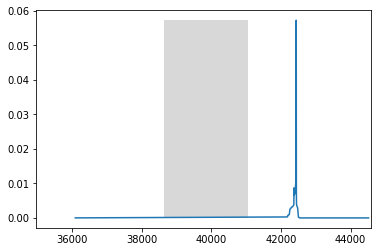

In [193]:
ir = ir2
xmin = pos_to_trim(ir[0]-3500)
xmax = pos_to_trim(ir[1]+3500)
aux = rrate.loc[xmin:xmax,:]
print np.nanmean(aux['Mean Rho/bp.'])

x = aux.index
y=aux['Mean Rho/bp.']
plt.plot(x,y)
currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((pos_to_trim(ir[0]),np.min(y)), pos_to_trim(ir[1])-pos_to_trim(ir[0]),np.max(y)-np.min(y), facecolor="grey",alpha = 0.3) )   

xx = np.round(pos_to_trim(ir[1]) + (pos_to_trim(ir[1])-pos_to_trim(ir[0]))/2)
#plt.text(xx, 0.15, r'$IR3 - region$',fontdict=font)
plt.xlim([xmin,xmax])
plt.show()


In [179]:
(pos_to_trim(ir[1]),np.min(y))

(41057, 1.0000000000000001e-05)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.


nan


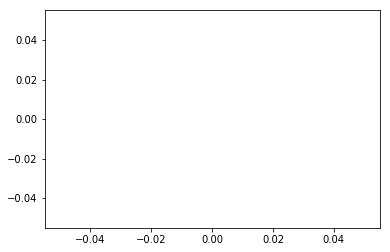

,Mean Rho/bp.,-95% CI,+95% CI
trimmed_position,,,


In [148]:
def pos_to_trim(p):
    if type(p) in [int,float] :
        tr = [x if x in mapp_dict.keys() else (x -1 ) for x in [p]]
    else:
        tr = [x if x in mapp_dict.keys() else (x -1 ) for x in p]
    return(get_items(mapp_dict,tr))


font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 16,
        }
x = aux.index
y=aux['Mean Rho/bp.']
plt.plot(x,y)
currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((ir[0]-1,np.min(y)), ir[1]-ir[0]+2,np.max(y)-np.min(y), facecolor="grey",alpha = 0.3) )   
#plt.text(96300, 0.15, r'$IR3 - region$',fontdict=font)
plt.show()


In [107]:
import re
from Bio import SeqIO
from Bio.Seq import Seq

rp3 = 'ggagcaggaggaggggcaggagcaggaggggcaggagcaggaggggcaggagcaggaggggcaggagcaggaggggcaggagcaggaggggcaggagcaggaggggcaggagcaggaggggcaggagcaggaggggcaggagcaggaggggcaggagcaggaggaggggcaggagcaggaggggcaggagcaggaggggcaggagcaggaggaggggcaggagcaggaggaggggcaggagcaggaggaggggcaggagcaggaggaggggcaggagcaggaggaggggcaggagcaggaggaggggcaggagcaggaggaggggcaggagcaggaggaggggcaggagcaggaggaggggcaggagcaggcggggcaggagcaggcggggcaggagcaggaggaggggcaggagcaggaggaggggcaggagcaggaggaggggcaggagcaggaggaggggcaggagcaggaggaggggcaggagcaggaggaggggcaggagcaggaggaggggcaggagcaggaggaggggcaggagcaggaggaggggcaggagcaggaggaggggcaggagcaggaggaggggcaggagcaggaggaggggcaggagcaggaggaggggcaggagcaggaggaggggcaggagcaggaggaggggcaggagcaggaggaggggcaggagcaggaggaggggcaggagcaggaggtg'
rp3start = rp3start[0:20].upper()

rp3end = rp3[-20:-1].upper()


def search_fasta(pattern, file_path):
    st = []
    end = []
    pat =[]
    reverse = str(Seq(pattern).reverse_complement())
    
    for patt in [pattern,reverse]:
        for record in SeqIO.parse(open(file_path, "rU"), "fasta"):
            chrom = record.id
            for match in re.finditer(patt, str(record.seq)):
                start_pos = match.start() + 1
                end_pos = match.end() + 1
                st.append(start_pos)
                end.append(end_pos)
                pat.append(patt)
    df = pd.DataFrame({'st':st,'end':end,'pattern':pat,'call':pattern})
    df = df[['st','end','pattern','call']]
    df.sort_values(by=['st'],inplace = True)
    
    return(df)

locir3s = search_fasta(pattern=rp3start,file_path='/data/EBV/byACCIDs/NC_007605.fasta')
locir3e = search_fasta(pattern=rp3end,file_path='/data/EBV/byACCIDs/NC_007605.fasta')
print (locir3s.iloc[0,:].st,locir3e.iloc[0,:].end)
#locir3.iloc[0,:].st


(95971, 96640)


In [18]:
    df = df.dropna(subset=[start_col,end_col])
    start_aux = [x if x in mapp_dict.keys() else (x +1 ) for x in df[start_col].values]
    end_aux = [x if x in mapp_dict.keys() else (x -1 ) for x in df[end_col].values]


    df['trimmed_st'] = get_items(mapp_dict,start_aux)
    df['trimmed_end'] = get_items(mapp_dict,end_aux)


,Mean Rho/bp.,-95% CI,+95% CI
trimmed_position,,,
10.0,0.00001,0.00001,0.00001
12.0,0.00001,0.00001,0.00001
16.0,0.00001,0.00001,0.00001


In [100]:
regions.columns

Index([u'st', u'end', u'call', u'GENE', u'length'], dtype='object')

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


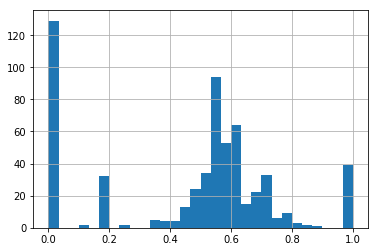

In [131]:
%matplotlib inline

def gc_content(seq):
    gs = seq.count('G')
    cs = seq.count('C')
    return (gs+cs)/float(len(seq))

reg_rho_gc = regions_rho[['call','GENE','Mean Rho/bp.','-95% CI','+95% CI']]
reg_rho_gc['gc'] = regions.apply(lambda x : gc_content(seq_record.seq[x.loc['st']: x.loc['end']]),1)
reg_rho_gc.gc.hist(bins = 30)

In [132]:
reg_rho_gc.columns

Index([u'call', u'GENE', u'Mean Rho/bp.', u'-95% CI', u'+95% CI', u'gc'], dtype='object')

In [186]:
from scipy import stats as sp
def mycorr(d):
    xx = d.gc.values
    yy = d['Mean Rho/bp.'].values
    return(sp.stats.pearsonr(xx, yy))


In [202]:
dat.index

Int64Index([1, 2, 3, 4, 6, 7, 0, 0, 1, 2,
            ...
            0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
           dtype='int64', length=318)

In [205]:
from matplotlib import pyplot as plt

dat = res3.dropna(subset = ['Mean Rho/bp.']).copy()

size_thr = 10
ok = dat.call.value_counts()
ii = ok[(ok>=size_thr)].index

dat2 = dat[dat.call.isin(ii)]
gb = dat2.groupby(['call'])[['gc','Mean Rho/bp.']].mean()
gb

#gc_rho_corr = gb.apply(lambda d: mycorr(d))

#plt.yscale('log')
#plt.scatter(dat.gc,dat['Mean Rho/bp.'])


#reg_rho_gc['Mean Rho/bp.']



,gc,Mean Rho/bp.
call,,
CDS,0.569376,0.021603
exon,0.526440,0.012504
gene,0.477476,0.019623
mRNA,0.562952,0.047790
misc_feature,0.847077,0.273662
regulatory,0.052083,0.013821
repeat_region,0.636237,0.114646


In [71]:
rrate.mean()

Mean Rho/bp.    0.035782
-95% CI         0.020210
+95% CI         0.062602
dtype: float64

In [208]:
gc = [0.6548,0.5566,0.5807,0.4486,0.5844,0.1599,0.768]
rho = [0.1613,0.0488,0.0163,0.0148,0.0105,0.0089,0.0078]
sp.stats.spearmanr(gc, rho)

SpearmanrResult(correlation=0.0, pvalue=1.0)